# Accelerating Cleantech Advancements through NLP-Powered Text Mining and Knowledge Extraction

Group: Marusa Storman, Vignesh Govindaraj, Pradip Ravichandran

## Stage 1: Enhanced Data Cleaning, Preprocessing, and Exploratory Analysis

### Data Collection

In [1]:
import sys
import os

# Get the directory of the current notebook
notebook_dir = os.getcwd()

# Change current working directory to where the notebook resides
os.chdir(notebook_dir)

# List of required libraries
required_libraries = [
    'json',
    #'language_data',
    'matplotlib',
    'nltk',
    'numpy',
    'pandas',
    'pyspellchecker',
    'scikit-learn',
    'seaborn',
    'string',
    'unidecode',
    'unicodedata',
    'wordcloud'
]

# Check if each library is installed, if not, install it
for lib in required_libraries:
    try:
        __import__(lib)
    except ImportError:
        print(f"Installing {lib}...")
        !"{sys.executable}" -m pip install {lib}

Installing pyspellchecker...
Installing scikit-learn...


In [2]:
import ast
import csv
import html
import json
#import langcodes
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
# import spacy
import string
import unidecode
import unicodedata

from collections import Counter
#from langcodes import *
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from spellchecker import SpellChecker
from urllib.parse import urlparse, urlunparse
from wordcloud import WordCloud


# Jupyter config
%config InteractiveShell.ast_node_interactivity = 'all'

# Additional setup for seaborn
sns.set(color_codes=True)
sns.set_style("whitegrid")

# Download needed NLTK's resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pradip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pradip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Read the JSON file from https://www.kaggle.com/datasets/prakharbhandari20/cleantech-google-patent-dataset
google_patent_original = pd.read_json("Data/original/bq-results-20240124-055833-1706076079048.json", lines=True)

# Read the first CSV file from https://www.kaggle.com/datasets/jannalipenkova/cleantech-media-dataset
media_original = pd.read_csv("Data/original/cleantech_media_dataset_v2_2024-02-23.csv")

# Read the second CSV file from https://www.kaggle.com/datasets/jannalipenkova/cleantech-media-dataset
media_evaluation_original = pd.read_csv("Data/original/cleantech_rag_evaluation_data_2024-02-23.csv")

In [4]:
# This function will provide with more useful information:
def analyze_column(df, has_list=False):
    info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Number of Entries': df.count(),
        'Missing/None Count': df.isna().sum()
    })
    
    if not has_list:
        info['Uniqueness'] = df.nunique()

    
    return info

print("Google Patent Dataset:")
google_patent_original.head()
analyze_column(google_patent_original, has_list=True)

Google Patent Dataset:


,publication_number,application_number,country_code,title_localized,abstract_localized,publication_date,inventor,cpc
0,US-2022239235-A1,US-202217717397-A,US,[{'text': 'Adaptable DC-AC Inverter Drive Syst...,[{'text': 'Disclosed is an adaptable DC-AC inv...,20220728,[],"[{'code': 'H02M7/5395', 'inventive': True, 'fi..."
1,US-2022239251-A1,US-202217580956-A,US,[{'text': 'System for providing the energy fro...,[{'text': 'In accordance with an example embod...,20220728,[],"[{'code': 'H02S40/38', 'inventive': True, 'fir..."
2,EP-4033090-A1,EP-21152924-A,EP,[{'text': 'Verfahren zum steuern einer windene...,[{'text': 'Verfahren zum Steuern einer Windene...,20220727,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...","[{'code': 'F03D7/0276', 'inventive': True, 'fi..."
3,EP-4033090-A1,EP-21152924-A,EP,[{'text': 'Verfahren zum steuern einer windene...,[{'text': 'Verfahren zum Steuern einer Windene...,20220727,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...","[{'code': 'F03D7/0276', 'inventive': True, 'fi..."
4,US-11396827-B2,US-202117606042-A,US,[{'text': 'Control method for optimizing solar...,[{'text': 'A control method for optimizing a s...,20220726,[],"[{'code': 'F24S50/00', 'inventive': True, 'fir..."


,Data Type,Number of Entries,Missing/None Count
publication_number,object,30000,0
application_number,object,30000,0
country_code,object,30000,0
title_localized,object,30000,0
abstract_localized,object,30000,0
publication_date,int64,30000,0
inventor,object,30000,0
cpc,object,30000,0


In [5]:
print("Media Dataset:")
media_original.head()
analyze_column(media_original)
print("\nNumber of duplicate rows:", media_original.duplicated().sum())

Media Dataset:


,Unnamed: 0,title,date,author,content,domain,url
0,1280,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,NaN,"[""Qatar Petroleum ( QP) is targeting aggressiv...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
1,1281,India Launches Its First 700 MW PHWR,2021-01-15,NaN,"[""• Nuclear Power Corp. of India Ltd. ( NPCIL)...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
2,1283,New Chapter for US-China Energy Trade,2021-01-20,NaN,"[""New US President Joe Biden took office this ...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
3,1284,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,NaN,"[""The slow pace of Japanese reactor restarts c...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
4,1285,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,NaN,"[""Two of New York City's largest pension funds...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...


,Data Type,Number of Entries,Missing/None Count,Uniqueness
Unnamed: 0,int64,9593,0,9593
title,object,9593,0,9569
date,object,9593,0,967
author,object,31,9562,7
content,object,9593,0,9588
domain,object,9593,0,19
url,object,9593,0,9593



Number of duplicate rows: 0


In [6]:
print("Media Evaluation Dataset:")
media_evaluation_original.head()
analyze_column(media_evaluation_original)
print("\nNumber of duplicate rows:", media_evaluation_original.duplicated().sum())

Media Evaluation Dataset:


,example_id,question_id,question,relevant_chunk,article_url
0,1,1,What is the innovation behind Leclanché's new ...,Leclanché said it has developed an environment...,https://www.sgvoice.net/strategy/technology/23...
1,2,2,What is the EU’s Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the...,https://www.sgvoice.net/policy/25396/eu-seeks-...
2,3,2,What is the EU’s Green Deal Industrial Plan?,The European counterpart to the US Inflation R...,https://www.pv-magazine.com/2023/02/02/europea...
3,4,3,What are the four focus areas of the EU's Gree...,The new plan is fundamentally focused on four ...,https://www.sgvoice.net/policy/25396/eu-seeks-...
4,5,4,When did the cooperation between GM and Honda ...,What caught our eye was a new hookup between G...,https://cleantechnica.com/2023/05/08/general-m...


,Data Type,Number of Entries,Missing/None Count,Uniqueness
example_id,int64,23,0,23
question_id,int64,23,0,21
question,object,23,0,21
relevant_chunk,object,23,0,23
article_url,object,23,0,21



Number of duplicate rows: 0


### Data Cleaning
To preserve the original dataframe, it has been copied for the cleaning stage.

In [7]:
google_patent_clean = google_patent_original.copy()
media_clean = media_original.copy()
media_evaluation_clean = media_evaluation_original.copy()

#### Google patent

In [8]:
# Change to date format
google_patent_clean['publication_date'] = pd.to_datetime(google_patent_clean['publication_date'], format='%Y%m%d')
print("Earliest date:", google_patent_clean['publication_date'].min())
print("Latest date:", google_patent_clean['publication_date'].max())

Earliest date: 2021-11-23 00:00:00
Latest date: 2022-07-28 00:00:00


In [9]:
#### Flatts the nested JSON objects
def flat_dict_data(df, column_name):
    flattened_rows = []
    
    for _, row in df.iterrows():
        # Get the list of values
        specific_column = row.get(column_name, [])

        # If the column is empty, append the original row
        if not specific_column or len(specific_column) == 0:
            flattened_rows.append(row)
        else:
            # Iterate through each value
            for specific_column_value in specific_column:
                # Check if the value is a dictionary
                if isinstance(specific_column_value, dict):
                    # Flatten the JSON object
                    flattened_row = {f"{column_name}_{key}": value for key, value in specific_column_value.items() if value}
    
                    # Append the modified row
                    flattened_rows.append({**row, **flattened_row})
                    
    # Create a new DataFrame
    flatten_df = pd.DataFrame(flattened_rows)
    flatten_df.drop(columns=[column_name], inplace=True)
    return flatten_df

#### Flatts an array
def flat_list_data(df, column_name):
    flattened_rows = []
    
    for _, row in df.iterrows():
        # Get the list of values
        specific_column = row.get(column_name, [])  

        # If the column is empty, append the original row
        if len(specific_column) == 0:
            row[column_name] = np.nan
            flattened_rows.append(row)
        else:
            # Iterate through each value
            for value in specific_column:
                new_row = row.copy()
                new_row[column_name] = value
                flattened_rows.append(new_row)
    
    # Create a new DataFrame from flattened_rows
    flatten_df = pd.DataFrame(flattened_rows)
    return flatten_df

google_patent_normalized = flat_dict_data(google_patent_clean, 'title_localized')
google_patent_normalized = flat_dict_data(google_patent_normalized, 'abstract_localized')
google_patent_normalized = flat_dict_data(google_patent_normalized, 'cpc')
google_patent_normalized = flat_list_data(google_patent_normalized, 'inventor')

google_patent_normalized.head()
analyze_column(google_patent_normalized)
google_patent_clean = google_patent_normalized.copy()

,publication_number,application_number,country_code,publication_date,inventor,title_localized_text,title_localized_language,abstract_localized_text,abstract_localized_language,cpc_code,cpc_inventive,cpc_first
0,US-2022239235-A1,US-202217717397-A,US,2022-07-28,NaN,Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en,H02M7/5395,True,NaN
1,US-2022239235-A1,US-202217717397-A,US,2022-07-28,NaN,Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en,H02J3/32,NaN,NaN
2,US-2022239235-A1,US-202217717397-A,US,2022-07-28,NaN,Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en,H02M1/32,True,NaN
3,US-2022239235-A1,US-202217717397-A,US,2022-07-28,NaN,Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en,H02J1/10,True,NaN
4,US-2022239235-A1,US-202217717397-A,US,2022-07-28,NaN,Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en,H02J3/381,True,NaN


,Data Type,Number of Entries,Missing/None Count,Uniqueness
publication_number,object,1435720,0,13412
application_number,object,1435720,0,13285
country_code,object,1435720,0,32
publication_date,datetime64[ns],1435720,0,165
inventor,object,1321315,114405,20294
title_localized_text,object,1435720,0,24943
title_localized_language,object,1435720,0,20
abstract_localized_text,object,1435720,0,26327
abstract_localized_language,object,1435720,0,18
cpc_code,object,1338087,97633,7097


##### Remove Column
The dataset contains two id's, the publication_number & application_number.

Publication Number: This refers to the unique identifier assigned to a patent document when it is published. Patent documents are typically published after a certain period following the filing of the patent application, regardless of whether the patent has been granted or not. The publication number allows easy reference to the published document and facilitates searches in patent databases.

Application Number: This is the unique identifier assigned to a patent application when it is filed with the relevant patent office. The application number remains associated with the patent application throughout the prosecution process until a decision is made to grant or reject the patent. It is used to track the progress of the application, including examination and publication stages.

In [10]:
print("publication_number")
print(f"Number of Entries: {google_patent_clean['publication_number'].count()}, Number of Unique Entries: {len(google_patent_clean['publication_number'].unique())}")
print("application_number")
print(f"Number of Entries: {google_patent_clean['application_number'].count()}, Number of Unique Entries: {len(google_patent_clean['application_number'].unique())}")

unique_combinations = google_patent_clean[['publication_number', 'application_number']].drop_duplicates()
unique_count = len(unique_combinations)
print("Combination of publication_number & application_number")
print(f"Number of Entries: {len(google_patent_clean)}, Number of Unique Entries: {unique_count}")

publication_number
Number of Entries: 1435720, Number of Unique Entries: 13412
application_number
Number of Entries: 1435720, Number of Unique Entries: 13285
Combination of publication_number & application_number
Number of Entries: 1435720, Number of Unique Entries: 13412


In [11]:
total_rows = len(google_patent_clean)

# Calculate missing rate for each column
missing_rate_inventor = google_patent_clean['inventor'].isnull().sum() / total_rows * 100
missing_rate_cpc_code = google_patent_clean['cpc_code'].isnull().sum() / total_rows * 100
missing_rate_cpc_inventive = google_patent_clean['cpc_inventive'].isnull().sum() / total_rows * 100
missing_rate_cpc_first = google_patent_clean['cpc_first'].isnull().sum() / total_rows * 100

# Print missing rates for each column
print("Missing rate for Inventor column:", missing_rate_inventor, "%")
print("Missing rate for CPC Code column:", missing_rate_cpc_code, "%")
print("Missing rate for CPC Inventive column:", missing_rate_cpc_inventive, "%")
print("Missing rate for CPC First column:", missing_rate_cpc_first, "%")

Missing rate for Inventor column: 7.96847574736021 %
Missing rate for CPC Code column: 6.800281391914859 %
Missing rate for CPC Inventive column: 47.291393865099046 %
Missing rate for CPC First column: 89.20708773298415 %


In our research, the **publication_number** holds greater relevance and encompasses a wider array of unique entries compared to the **application_number**.

By analyzing missing values, certain columns stand out with notably high missing rates:

| Column           | Missing Rate  |
|------------------|---------------|
| Inventor         | 7.97%         |
| CPC Code         | 6.80%         |
| CPC Inventive    | 47.29%        |
| CPC First        | 89.20%        |

**Inventor:** This column contains the name or names of the person or people who came up with the idea for the patented invention. Basically, it tells us who invented the thing that the patent is about.

**CPC Code:** This column holds a special code that helps classify patents based on what they're about. It's like a label that describes the type of invention that the patent covers. For example, there might be different codes for inventions related to solar power, recycling, or clean water technologies.

**CPC Inventive:** This column tells us whether the patent covers something new and innovative. If it says "True," it means the patent is for an invention that's considered creative or original. If it's blank (NaN), it means we don't have information about whether the invention is inventive or not.

**CPC First:** This column indicates the main category or area that the patent belongs to. It's like the big picture topic of the invention. For instance, a patent about a new type of wind turbine might have a "Wind Energy" code in this column. Like `CPC Inventive`, if it says "True," it means there's a main category assigned to the patent. If it's blank, we don't have that information.

The columns `CPC First` and `CPC Inventive` seem to have no relevance to our research.


In [12]:
google_patent_clean.drop(['application_number', 'cpc_inventive', 'cpc_first'], axis=1, inplace=True)

##### Drop duplicates

In [13]:
# Calculate the number of duplicate rows
duplicate_rows = google_patent_clean.duplicated(keep='first').sum()

# Calculate the percentage of duplicate rows
percentage_duplicates = (duplicate_rows / len(google_patent_clean)) * 100

print(f"Duplicate rows: {duplicate_rows}")
print(f"Percentage of duplicate rows: {percentage_duplicates:.2f}%")

Duplicate rows: 983839
Percentage of duplicate rows: 68.53%


In [14]:
# Display some duplicate rows to inspect them
duplicates_to_inspect = google_patent_clean[google_patent_clean.duplicated(keep=False)]
duplicates_to_inspect.head()

,publication_number,country_code,publication_date,inventor,title_localized_text,title_localized_language,abstract_localized_text,abstract_localized_language,cpc_code
12,EP-4033090-A1,EP,2022-07-27,"Schaper, Ulf",Verfahren zum steuern einer windenergieanlage,de,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0276
12,EP-4033090-A1,EP,2022-07-27,"von Aswege, Enno",Verfahren zum steuern einer windenergieanlage,de,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0276
12,EP-4033090-A1,EP,2022-07-27,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,de,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0276
13,EP-4033090-A1,EP,2022-07-27,"Schaper, Ulf",Verfahren zum steuern einer windenergieanlage,de,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0296
13,EP-4033090-A1,EP,2022-07-27,"von Aswege, Enno",Verfahren zum steuern einer windenergieanlage,de,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0296


In [15]:
# Deeper analyses
duplicates_filtered = google_patent_clean[(google_patent_clean['publication_number'] == 'EP-4033090-A1') & (google_patent_clean['title_localized_language'] == 'de')]

# Show only the specified columns
duplicates_filtered[['country_code', 'publication_date', 'inventor', 'title_localized_text', 'abstract_localized_text', 'abstract_localized_language', 'cpc_code']]

,country_code,publication_date,inventor,title_localized_text,abstract_localized_text,abstract_localized_language,cpc_code
12,EP,2022-07-27,"Schaper, Ulf",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0276
12,EP,2022-07-27,"von Aswege, Enno",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0276
12,EP,2022-07-27,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0276
13,EP,2022-07-27,"Schaper, Ulf",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0296
13,EP,2022-07-27,"von Aswege, Enno",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0296
13,EP,2022-07-27,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0296
14,EP,2022-07-27,"Schaper, Ulf",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/028
14,EP,2022-07-27,"von Aswege, Enno",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/028
14,EP,2022-07-27,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/028
15,EP,2022-07-27,"Schaper, Ulf",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0276


In [16]:
# Deeper analyses
duplicates_filtered[['inventor', 'title_localized_text', 'abstract_localized_text', 'cpc_code']].sort_values(by=['inventor', 'cpc_code'])

,inventor,title_localized_text,abstract_localized_text,cpc_code
12,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/0276
15,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/0276
30,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/0276
33,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/0276
14,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/028
17,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/028
32,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/028
35,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/028
13,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/0296
16,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/0296


In [17]:
# Columns to group by, excluding 'cpc_code' and 'inventor'
group_columns = [col for col in google_patent_clean.columns if col not in ('cpc_code', 'inventor')]

# Group by these columns and aggregate 'cpc_code' and 'inventor' to see unique entries
grouped = google_patent_clean.groupby(group_columns).agg({'cpc_code': ['unique', 'nunique'], 'inventor': 'nunique'}).reset_index()

# Flatten the multi-level column index
grouped.columns = ['_'.join(col) if col[1] != '' else col[0] for col in grouped.columns]

# Sort the DataFrame based on the number of unique CPC codes and inventor to see the groups with the most variety
grouped_sorted = grouped.sort_values(by=['cpc_code_nunique', 'inventor_nunique'], ascending=False)

# Display the top entries with the most variety
grouped_sorted.head()

,publication_number,country_code,publication_date,title_localized_text,title_localized_language,abstract_localized_text,abstract_localized_language,cpc_code_unique,cpc_code_nunique,inventor_nunique
17,AU-2020336047-A1,AU,2022-03-03,Solar powered display assemblies,en,Solar powered display assemblies and systems a...,en,"[Y02T10/70, Y02E70/30, Y02E10/56, Y02B10/10, H...",45,4
51281,EP-4022595-A1,EP,2022-07-06,Ensembles d&#39;affichage à énergie solaire,fr,La présente invention concerne des ensembles d...,fr,"[B60Y2400/60, E04H1/1211, B60Y2300/91, H02S20/...",45,4
51282,EP-4022595-A1,EP,2022-07-06,Ensembles d&#39;affichage à énergie solaire,fr,Solar powered display assemblies and systems a...,en,"[B60Y2400/60, E04H1/1211, B60Y2300/91, H02S20/...",45,4
51283,EP-4022595-A1,EP,2022-07-06,Solar powered display assemblies,en,La présente invention concerne des ensembles d...,fr,"[B60Y2400/60, E04H1/1211, B60Y2300/91, H02S20/...",45,4
51284,EP-4022595-A1,EP,2022-07-06,Solar powered display assemblies,en,Solar powered display assemblies and systems a...,en,"[B60Y2400/60, E04H1/1211, B60Y2300/91, H02S20/...",45,4


Given certain circumstances, there are instances where identical rows appear multiple times in the dataset. This occurrence is primarily due to patents being categorized into various categories (`cpc_code`) and often involves collaboration among multiple `inventors`. Therefore, it's not uncommon to find the same patent represented multiple times, reflecting its presence in different categories and co-authored by different individuals.

In [18]:
print(f"Number of rows: {len(google_patent_clean)}")

# Find duplicate rows
duplicates = google_patent_clean.duplicated(keep='first')

# Count the duplicates
print(f"Number of duplicate rows: {duplicates.sum()}")

# Drop the duplicates
google_patent_clean = google_patent_clean[~duplicates].reset_index(drop=True)

# extra code to make sure both calculate the same amount of duplicates 334190, and 0 after dropping
print(f"Number of rows after removing: {len(google_patent_clean)}")

Number of rows: 1435720
Number of duplicate rows: 983839
Number of rows after removing: 451881


##### Clean Text

In [19]:
google_patent_clean[google_patent_clean['publication_number'] == 'EP-4022595-A1']['title_localized_text'].iloc[0]

'Ensembles d&#39;affichage à énergie solaire'

In this example, it's evident that the text needs to be unescaped.

In [20]:
google_patent_clean[['title_localized_text', 'abstract_localized_text']] = google_patent_clean[['title_localized_text', 'abstract_localized_text']].map(html.unescape)
html.unescape(google_patent_clean[google_patent_clean['publication_number'] == 'EP-4022595-A1']['title_localized_text'].iloc[0])

"Ensembles d'affichage à énergie solaire"

In [21]:
google_patent_clean[google_patent_clean['publication_number'] == 'AU-2022204705-A1']['abstract_localized_text'].iloc[0]

'Cladding sheets (9), such as roof or wall cladding sheets, include mounting \nsections (21) for mounting solar panels (35) on the sheets and support sections (23) for \n5 supporting the mounting sections of other cladding sheets. A roof or a wall of a \nbuilding formed from the cladding sheets includes air flow ducts (27) extending along \nthe length of the cladding sheets and underlying the mounting sections in heat transfer \nrelationship with the mounting sections for heating or cooling air flowing through the \nducts. A system for generating electrical energy and thermal energy from solar energy \n10 converts solar energy incident on solar panels on the roof or the wall into electrical \nenergy and thermal energy and converts solar energy that is otherwise incident on the \nroof or wall into thermal energy. An integrated heating and cooling system for a \nbuilding collects and transfers air that has been heated or cooled by the roof or the wall \nas it flows through the air flow d

It's evident that there are multiple '\n' characters present. These could potentially cause issues later on, whether it's when saving the text to a CSV file or during text processing tasks.

In [22]:
google_patent_clean['abstract_localized_text'] = google_patent_clean['abstract_localized_text'].str.replace('\n', '')
google_patent_clean[google_patent_clean['publication_number'] == 'AU-2022204705-A1']['abstract_localized_text'].iloc[0]

'Cladding sheets (9), such as roof or wall cladding sheets, include mounting sections (21) for mounting solar panels (35) on the sheets and support sections (23) for 5 supporting the mounting sections of other cladding sheets. A roof or a wall of a building formed from the cladding sheets includes air flow ducts (27) extending along the length of the cladding sheets and underlying the mounting sections in heat transfer relationship with the mounting sections for heating or cooling air flowing through the ducts. A system for generating electrical energy and thermal energy from solar energy 10 converts solar energy incident on solar panels on the roof or the wall into electrical energy and thermal energy and converts solar energy that is otherwise incident on the roof or wall into thermal energy. An integrated heating and cooling system for a building collects and transfers air that has been heated or cooled by the roof or the wall as it flows through the air flow ducts of the roof or th

#### Cleantech Media

Since the `Unnamed: 0` column appears to be the index, and we lack additional context about its significance, this particular index does not seem to provide any useful information.

In [23]:
# Change to date format
media_clean['date'] = pd.to_datetime(media_clean['date'], format='ISO8601')
print("Earliest date:", media_clean['date'].min())
print("Latest date:", media_clean['date'].max())

# Google patent time
# Earliest date: 2021-11-23 00:00:00
# Latest date: 2022-07-28 00:00:00
# The articles in cleantech media start much earlier and go longer
# Information can be there before the patent publication and after, so shall we filter the dataset?

# Remove index column
media_clean = media_clean.drop(columns=['Unnamed: 0'])

media_clean.head()
analyze_column(media_clean)

Earliest date: 2021-01-01 00:00:00
Latest date: 2023-12-05 00:00:00


,title,date,author,content,domain,url
0,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,NaN,"[""Qatar Petroleum ( QP) is targeting aggressiv...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
1,India Launches Its First 700 MW PHWR,2021-01-15,NaN,"[""• Nuclear Power Corp. of India Ltd. ( NPCIL)...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
2,New Chapter for US-China Energy Trade,2021-01-20,NaN,"[""New US President Joe Biden took office this ...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
3,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,NaN,"[""The slow pace of Japanese reactor restarts c...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
4,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,NaN,"[""Two of New York City's largest pension funds...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...


,Data Type,Number of Entries,Missing/None Count,Uniqueness
title,object,9593,0,9569
date,datetime64[ns],9593,0,967
author,object,31,9562,7
content,object,9593,0,9588
domain,object,9593,0,19
url,object,9593,0,9593


##### Analyse Content Column


In [24]:
# Convert the 'content' column from string to list
media_clean['content_list'] = media_clean['content'].apply(ast.literal_eval)

# Filter rows with empty lists and calculate count
empty_count = media_clean[media_clean['content_list'].apply(lambda x: isinstance(x, list) and len(x) == 0)].shape[0]

# Calculate average length of non-empty lists
non_empty_avg_length = media_clean[media_clean['content_list'].apply(lambda x: isinstance(x, list) and len(x) > 0)]['content_list'].apply(len).mean()

print("Number of rows with empty lists in 'content_list' column:", empty_count)
if not np.isnan(non_empty_avg_length):
    print("Average length of non-empty lists in 'content_list' column: {:.2f}".format(non_empty_avg_length))


Number of rows with empty lists in 'content_list' column: 0
Average length of non-empty lists in 'content_list' column: 18.91


In [25]:
# Filter rows where content has a list length of at least 2
media_clean[media_clean['content_list'].apply(lambda x: len(x) >= 2)]

,title,date,author,content,domain,url,content_list
19,Oil Is Vital to Decarbonizing,2021-04-05,NaN,['We talk increasingly about “ critical minera...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,[We talk increasingly about “ critical mineral...
27,Capturing the Moment: Carbon Capture in the Am...,2021-04-20,NaN,['President Biden’ s $ 2.25 trillion-plus Amer...,energyintel,https://nam02.safelinks.protection.outlook.com...,[President Biden’ s $ 2.25 trillion-plus Ameri...
82,Critiquing Criticisms of Renewables,2021-09-17,NaN,"[""While every energy scenario assumes thousand...",energyintel,https://www.energyintel.com/0000017b-f422-d9ef...,[While every energy scenario assumes thousands...
83,US Majors Define Their Brand of Decarbonization,2021-09-21,NaN,['Shareholders have demanded more aggressive d...,energyintel,https://www.energyintel.com/0000017c-0593-dab9...,[Shareholders have demanded more aggressive de...
84,Ecopetrol Eyes Cleaner Hydrogen in Net-Zero Push,2021-10-06,NaN,['Colombian state oil producer Ecopetrol is ey...,energyintel,https://www.energyintel.com/0000017c-4d23-d3a0...,[Colombian state oil producer Ecopetrol is eye...
...,...,...,...,...,...,...,...
9588,Strata Clean Energy Nets $ 300 Million in Fund...,2023-11-06,NaN,['Strata Clean Energy has closed a $ 300 milli...,solarindustrymag,https://solarindustrymag.com/strata-clean-ener...,[Strata Clean Energy has closed a $ 300 millio...
9589,Orsted Deploying SparkCognition Renewable Suit...,2023-11-07,NaN,['Global renewable energy developer Ørsted is ...,solarindustrymag,https://solarindustrymag.com/orsted-deploying-...,[Global renewable energy developer Ørsted is d...
9590,Veolia Has Plans for 5 MW of Solar in Arkansas,2023-11-07,NaN,"['Veolia North America, a provider of environm...",solarindustrymag,https://solarindustrymag.com/veolia-has-plans-...,"[Veolia North America, a provider of environme..."
9591,"SunEdison: Too Big, Too Fast?",2023-11-08,NaN,['Once the self-proclaimed “ leading renewable...,solarindustrymag,http://www.solarindustrymag.com/online/issues/...,[Once the self-proclaimed “ leading renewable ...


In [26]:
media_clean['content_list'][19][0]
media_clean['content_list'][19][1]
media_clean['content_list'][19][2]

'We talk increasingly about “ critical minerals, ” sources for elements spanning the periodic table that are vital, considered to be strategically important, and for which substitutes are very difficult and expensive or simply nonexistent. In the grand competition among nation states to decarbonize and reach “ net zero, ” the rush of one-upmanship ignores an important truth: Hydrocarbons are critical minerals, permeating all facets of human existence and endeavor. The myriad activist pressures and government responses to limit, ban or otherwise penalize access to the extraction of and use of the most common sources of hydrocarbon molecules -- petroleum and natural gas -- are unwise, risky and represent forms of trade restrictions. Oil and gas are actually essential to the development of alternative sources of energy and decarbonization.'

'Government actions in opposition to oil and gas introduce a range of potentially dangerous insecurities. We have been there, and done all of this before with oil and seen the consequences. That past experience, in large part, underlies notions of the criticality of minerals.'

'The fundamental dilemma remains that both energy and materials are required and essential. Public understanding of the economic rudiments of hydrocarbons is poor. Lack of awareness makes it easy to ignore economic realities underlying the supply of hydrocarbons and the enormous variety of products derived from them. Most important and by far the biggest hurdle in decarbonizing is the leveraging of fuels and materials that hydrocarbons afford -- including the storage of energy inherent in these fuels. Hydrocarbon co-products and byproducts are building blocks for intermediate and final goods we use every day. By amortizing costs of extracting, processing and manufacturing across fuels and materials the outcome is an achievement of scale and scope that makes everyday products affordable.'

Upon analyzing the `content` column, it becomes apparent that the data structure originally comprised a list that has since been converted into a string. Each element within the list corresponds to a paragraph, and these paragraphs are interconnected.

In [27]:
def most_common_paragraph(df, max_number=20):
    # Flatten the list and filter out empty paragraphs
    all_content = [paragraph for row in df for paragraph in row if paragraph]
    
    # Create a counter and get the 20 most common elements
    counter = Counter(all_content)
    most_common = counter.most_common(max_number)
    
    # Add the index number to each most common paragraph
    return [(i, item[0], item[1]) for i, item in enumerate(most_common)]
     

most_common_100 = most_common_paragraph(media_clean['content_list'], 100)
most_common_100

[(0,
  'Copyright © 2023 CleanTechnica. The content produced by this site is for entertainment purposes only. Opinions and comments published on this site may not be sanctioned by and do not necessarily represent the views of CleanTechnica, its owners, sponsors, affiliates, or subsidiaries.',
  1861),
 (1,
  "This International Women's Day, AZoCleantech spoke to inspiring women who have made a difference in the Clean Technology field. For this interview, we spoke to Dr. Adina Rom, the Executive Director of ETH for Development.",
  1629),
 (2,
  "In this interview, AZoCleantech speaks with Tebogo Maleka, National Project Coordinator at the United Nations Industrial Development Organization ( UNIDO), about her role within the organization and the initiative that aims to support South Africa's transition from conventional plastics to more environmentally sustainable alternatives.",
  1628),
 (3,
  "AZoCleantech recently spoke to entrepreneur Siân Sutherland, the Co-Founder of A Plastic Pl

It's evident that some paragraphs are repeating and are not important for our analysis. Therefore, let's remove them.

In [28]:
# Define a function to filter out unwanted paragraphs
def filter_paragraphs(paragraphs, paragraphs_to_remove):
    return [paragraph for paragraph in paragraphs if paragraph not in paragraphs_to_remove]

# Select paragraphs which needed to be removed
to_remove = [most_common_100[i][1] for i in [0, 4] + list(range(8, 20)) + list(range(21, 41)) 
             + list(range(43, 52)) + [53, 54, 55, 57] + list(range(59, 65)) 
             + [68, 69, 70, 71, 73, 74, 75, 77, 78, 80, 81, 82, 84, 85, 86, 88, 90, 93, 94, 96, 98, 99]]

# Apply the function to each row in 'content_list'
media_clean['content_list'] = media_clean['content_list'].apply(lambda row: filter_paragraphs(row, to_remove))

# Display the updated DataFrame
most_common_50 = most_common_paragraph(media_clean['content_list'], 50)
most_common_50

[(0,
  "This International Women's Day, AZoCleantech spoke to inspiring women who have made a difference in the Clean Technology field. For this interview, we spoke to Dr. Adina Rom, the Executive Director of ETH for Development.",
  1629),
 (1,
  "In this interview, AZoCleantech speaks with Tebogo Maleka, National Project Coordinator at the United Nations Industrial Development Organization ( UNIDO), about her role within the organization and the initiative that aims to support South Africa's transition from conventional plastics to more environmentally sustainable alternatives.",
  1628),
 (2,
  "AZoCleantech recently spoke to entrepreneur Siân Sutherland, the Co-Founder of A Plastic Planet, for International Women's Day. Her company's goal is to inspire the world to turn off the plastic tap to help reduce its burden on the planet.",
  1628),
 (3,
  'The Sensi+™ is a laser-based analyzer used for monitoring natural gas quality.',
  1627),
 (4,
  'The Cypher ES AFM from Oxford Instrum

In [29]:
to_remove = [most_common_50[i][1] for i in [27, 28, 29, 33, 34, 38, 39, 40, 41] + list(range(45, 50))]
media_clean['content_list'] = media_clean['content_list'].apply(lambda row: filter_paragraphs(row, to_remove))
most_common_20 = most_common_paragraph(media_clean['content_list'])
most_common_20

[(0,
  "This International Women's Day, AZoCleantech spoke to inspiring women who have made a difference in the Clean Technology field. For this interview, we spoke to Dr. Adina Rom, the Executive Director of ETH for Development.",
  1629),
 (1,
  "In this interview, AZoCleantech speaks with Tebogo Maleka, National Project Coordinator at the United Nations Industrial Development Organization ( UNIDO), about her role within the organization and the initiative that aims to support South Africa's transition from conventional plastics to more environmentally sustainable alternatives.",
  1628),
 (2,
  "AZoCleantech recently spoke to entrepreneur Siân Sutherland, the Co-Founder of A Plastic Planet, for International Women's Day. Her company's goal is to inspire the world to turn off the plastic tap to help reduce its burden on the planet.",
  1628),
 (3,
  'The Sensi+™ is a laser-based analyzer used for monitoring natural gas quality.',
  1627),
 (4,
  'The Cypher ES AFM from Oxford Instrum

In [30]:
# Join the list elements with '\n\n'
media_clean['content'] = media_clean['content_list'].apply(lambda x: '\n\n'.join(x))

media_clean['content'] = media_clean['content'].str.replace('( ', '(')

# Calculate average length of non-empty lists
non_empty_avg_length = media_clean[~media_clean['content'].isnull()]['content'].apply(len).mean()
print("Average length of non-empty content in 'content_list' column: {:.2f}".format(non_empty_avg_length))

print(media_clean['content'][19])
media_clean = media_clean.drop(columns=['content_list'])

Average length of non-empty content in 'content_list' column: 4461.81
We talk increasingly about “ critical minerals, ” sources for elements spanning the periodic table that are vital, considered to be strategically important, and for which substitutes are very difficult and expensive or simply nonexistent. In the grand competition among nation states to decarbonize and reach “ net zero, ” the rush of one-upmanship ignores an important truth: Hydrocarbons are critical minerals, permeating all facets of human existence and endeavor. The myriad activist pressures and government responses to limit, ban or otherwise penalize access to the extraction of and use of the most common sources of hydrocarbon molecules -- petroleum and natural gas -- are unwise, risky and represent forms of trade restrictions. Oil and gas are actually essential to the development of alternative sources of energy and decarbonization.

Government actions in opposition to oil and gas introduce a range of potentially 

In [31]:
media_clean['content'] = media_clean['content'].str.replace('\n\n', '  ')

##### Analyse URL Column

In [32]:
media_clean['url'] = media_clean['url'].astype(str)

# Remove everything after "#" symbol in the URL
media_clean['url'] = media_clean['url'].str.split('#').str[0]

# Remove "https://", "http://", and "www." from the URLs
media_clean['url'] = media_clean['url'].str.replace('https://', '').str.replace('http://', '').str.replace('www.', '')

# Remove the domain and ".com" from the URLs
media_clean['url'] = media_clean.apply(lambda row: row['url'].replace(row['domain'] + '.com', ''), axis=1)

# Strip leading and trailing slashes from the URLs
media_clean['url'] = media_clean['url'].str.strip('/')

# Analyse the url
url_split = media_clean['url'].str.split('/', expand=True)
analyze_column(url_split)
url_split
url_split.apply(lambda col: col.unique())

,Data Type,Number of Entries,Missing/None Count,Uniqueness
0,object,9593,0,3952
1,object,5740,3853,1911
2,object,4839,4754,1868
3,object,3336,6257,2935
4,object,457,9136,347
5,object,54,9539,34


,0,1,2,3,4,5
0,0000017b-a7dc-de4c-a17b-e7de685b0000,None,None,None,None,None
1,0000017b-a7dc-de4c-a17b-e7de6c710001,None,None,None,None,None
2,0000017b-a7dc-de4c-a17b-e7de735a0000,None,None,None,None,None
3,0000017b-a7dc-de4c-a17b-e7de79160000,None,None,None,None,None
4,0000017b-a7dc-de4c-a17b-e7de7d9e0000,None,None,None,None,None
...,...,...,...,...,...,...
9588,strata-clean-energy-nets-300-million-in-fundin...,None,None,None,None,None
9589,orsted-deploying-sparkcognition-renewable-suit...,None,None,None,None,None
9590,veolia-has-plans-for-5-mw-of-solar-in-arkansas,None,None,None,None,None
9591,online,issues,SI1606,FEAT_01_SunEdison-Too-Big-Too-Fast.html,None,None


0    [0000017b-a7dc-de4c-a17b-e7de685b0000, 0000017...
1    [None, ?url=https%3A%2F%2Frhg.com%2Fresearch%2...
2    [None, neccus-industrial-decarbonisation-roadm...
3    [None, 289624, mubadala-top-10, 290119, offsho...
4    [None, falck-renewables-bluefloat-energy-float...
5    [None, scotwind-cromarty-firth-aberdeen-harbou...
dtype: object

##### Drop duplicates

In [33]:
print(f"Number of rows: {len(media_clean)}")

# Find duplicate rows
duplicates = media_clean.duplicated(keep='first')
duplicates_title = media_clean.duplicated(subset=['title', 'domain'], keep='first')
duplicates_content = media_clean.duplicated(subset=['content', 'domain'], keep='first')
duplicates_title_content = media_clean.duplicated(subset=['title', 'content', 'domain'], keep='first')

# Count the duplicates
print(f"Number of duplicate rows: {duplicates.sum()}")
print(f"Number of duplicate rows title wise: {duplicates_title.sum()}")
print(f"Number of duplicate rows content wise: {duplicates_content.sum()}")
print(f"Number of duplicate rows title-content wise: {duplicates_title_content.sum()}")

Number of rows: 9593
Number of duplicate rows: 0
Number of duplicate rows title wise: 24
Number of duplicate rows content wise: 5
Number of duplicate rows title-content wise: 0


Some content has been republished by the same domain but with different titles. Additionally, some titles have been reused for different content.

#### Cleantech Media Evalution
In the Dataset Cleantech Media Evaluation, no data cleaning is necessary. However, it could be beneficial to extract the domain from the article URL.

In [34]:
# Extract domain from article_url
media_evaluation_clean['domain'] = media_evaluation_clean['article_url'].apply(lambda x: urlparse(x).netloc.replace('www.', ''))
media_evaluation_clean

,example_id,question_id,question,relevant_chunk,article_url,domain
0,1,1,What is the innovation behind Leclanché's new ...,Leclanché said it has developed an environment...,https://www.sgvoice.net/strategy/technology/23...,sgvoice.net
1,2,2,What is the EU’s Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the...,https://www.sgvoice.net/policy/25396/eu-seeks-...,sgvoice.net
2,3,2,What is the EU’s Green Deal Industrial Plan?,The European counterpart to the US Inflation R...,https://www.pv-magazine.com/2023/02/02/europea...,pv-magazine.com
3,4,3,What are the four focus areas of the EU's Gree...,The new plan is fundamentally focused on four ...,https://www.sgvoice.net/policy/25396/eu-seeks-...,sgvoice.net
4,5,4,When did the cooperation between GM and Honda ...,What caught our eye was a new hookup between G...,https://cleantechnica.com/2023/05/08/general-m...,cleantechnica.com
5,6,5,Did Colgate-Palmolive enter into PPA agreement...,"Scout Clean Energy, a Colorado-based renewable...",https://solarindustrymag.com/scout-and-colgate...,solarindustrymag.com
6,7,6,What is the status of ZeroAvia's hydrogen fuel...,"In December, the US startup ZeroAvia announced...",https://cleantechnica.com/2023/01/02/the-wait-...,cleantechnica.com
7,8,7,"What is the ""Danger Season""?",As spring turns to summer and the days warm up...,https://cleantechnica.com/2023/05/15/what-does...,cleantechnica.com
8,9,8,Is Mississipi an anti-ESG state?,Mississippi is among two dozen or so states in...,https://cleantechnica.com/2023/05/15/mississip...,cleantechnica.com
9,10,9,Can you hang solar panels on garden fences?,Scaling down from the farm to the garden level...,https://cleantechnica.com/2023/05/18/solar-pan...,cleantechnica.com


### Detect languages 

In [35]:
google_patent_lang = google_patent_clean.copy()
ct_media = media_clean.copy()
ct_evaluation = media_evaluation_clean.copy()

The Cleantech records are in English only, so no additional language recognition is required.

In [36]:
ct_media.to_csv(f"Data/ct_media_clean.csv", index=False)
ct_evaluation.to_csv(f"Data/ct_evaluation_clean.csv", index=False)

#### Google patent

In [37]:
# Get counts for title and abstract languages
title_language_counts = google_patent_lang['title_localized_language'].value_counts().reset_index().rename(columns={'title_localized_language': 'language', 'count': 'title_count'})
abstract_language_counts = google_patent_lang['abstract_localized_language'].value_counts().reset_index().rename(columns={'abstract_localized_language': 'language', 'count': 'abstract_count'})

# Merge the two dataframes on the 'language' column
combined_language_counts = pd.merge(title_language_counts, abstract_language_counts, on='language', how='outer').fillna(0)

# Display the combined dataframe
combined_language_counts.sort_values(by='title_count', ascending=False)

,language,title_count,abstract_count
3,en,226961,228187.0
19,zh,204974,204936.0
6,fr,13411,13515.0
1,de,3522,1488.0
10,ko,1155,2007.0
16,ru,800,605.0
9,ja,363,484.0
0,ar,224,221.0
4,es,161,161.0
15,ro,102,102.0


In [38]:
# Group by title and abstract localized languages, aggregate unique publication numbers, and calculate count
lang_distribution = google_patent_lang.groupby(['title_localized_language', 'abstract_localized_language'])['publication_number'].agg(publication_numbers=list, count='count').reset_index()
# lang_distribution['title_localized_language'] = lang_distribution['title_localized_language'].apply(lambda x: Language.make(language=x).display_name())
# lang_distribution['abstract_localized_language'] = lang_distribution['abstract_localized_language'].apply(lambda x: Language.make(language=x).display_name())

# Sort by count in descending order
lang_distribution = lang_distribution.sort_values(by='count', ascending=False)

# Filter out rows with count less than 10
remove_rows = lang_distribution[lang_distribution['count'] < 10].copy()

# Create a new column with tuple of language combinations
remove_rows.loc[:, 'lang_tuple'] = list(zip(remove_rows['title_localized_language'], remove_rows['abstract_localized_language']))

# Drop unnecessary columns
remove_rows = remove_rows.drop(columns=['title_localized_language', 'abstract_localized_language'])

remove_rows

,publication_numbers,count,lang_tuple
54,"[WO-2022056615-A1, WO-2022056615-A1, WO-202205...",7,"(pt, pt)"
53,"[WO-2022056615-A1, WO-2022056615-A1, WO-202205...",7,"(pt, fr)"
21,"[WO-2022056615-A1, WO-2022056615-A1, WO-202205...",7,"(en, pt)"
50,"[LV-15648-A, LV-15648-A, LV-15648-A, LV-15648-...",7,"(lv, lv)"
52,"[WO-2022056615-A1, WO-2022056615-A1, WO-202205...",7,"(pt, en)"
47,"[LT-6891-B, LT-6877-B, LT-6877-B, LT-6877-B, L...",7,"(lt, en)"
49,"[LV-15648-A, LV-15648-A, LV-15648-A, LV-15648-...",7,"(lv, en)"
48,"[LT-6891-B, LT-6877-B, LT-6877-B, LT-6877-B, L...",7,"(lt, lt)"
37,"[WO-2022056615-A1, WO-2022056615-A1, WO-202205...",7,"(fr, pt)"
18,"[LT-6891-B, LT-6877-B, LT-6877-B, LT-6877-B, L...",7,"(en, lt)"


In [39]:
combined_filtered_rows = google_patent_lang[(google_patent_lang['publication_number'].isin(list(set(remove_rows['publication_numbers'].sum())))) & 
                                      (google_patent_lang[['title_localized_language', 'abstract_localized_language']]
                                       .apply(tuple, axis=1)
                                       .isin(list(remove_rows['lang_tuple'])))]

combined_filtered_index = combined_filtered_rows.index
google_patent_lang.drop(combined_filtered_index, inplace=True)

In [40]:
# Get counts for title and abstract languages
title_language_counts = google_patent_lang['title_localized_language'].value_counts().reset_index().rename(columns={'title_localized_language': 'language', 'count': 'title_count'})
abstract_language_counts = google_patent_lang['abstract_localized_language'].value_counts().reset_index().rename(columns={'abstract_localized_language': 'language', 'count': 'abstract_count'})

# Merge the two dataframes on the 'language' column
combined_language_counts = pd.merge(title_language_counts, abstract_language_counts, on='language', how='outer').fillna(0)

# Display the combined dataframe
combined_language_counts.sort_values(by='title_count', ascending=False)

,language,title_count,abstract_count
2,en,226928,228155.0
11,zh,204974,204936.0
5,fr,13401,13502.0
1,de,3522,1488.0
7,ko,1155,2007.0
9,ru,800,605.0
6,ja,363,484.0
0,ar,218,218.0
3,es,161,161.0
8,ro,102,102.0


In [41]:
google_patent_lang = google_patent_lang[google_patent_lang['title_localized_language'] != "sv"]
# Get counts for title and abstract languages
title_language_counts = google_patent_lang['title_localized_language'].value_counts().reset_index().rename(columns={'title_localized_language': 'language', 'count': 'title_count'})
abstract_language_counts = google_patent_lang['abstract_localized_language'].value_counts().reset_index().rename(columns={'abstract_localized_language': 'language', 'count': 'abstract_count'})

# Merge the two dataframes on the 'language' column
combined_language_counts = pd.merge(title_language_counts, abstract_language_counts, on='language', how='outer').fillna(0)

# Display the combined dataframe
combined_language_counts.sort_values(by='title_count', ascending=False)

,language,title_count,abstract_count
2,en,226928,228121
10,zh,204974,204936
5,fr,13401,13502
1,de,3522,1488
7,ko,1155,2007
9,ru,800,605
6,ja,363,484
0,ar,218,218
3,es,161,161
8,ro,102,102


The less frequently used languages have been excluded, while all remaining languages have been exported to a separate CSV file.

In [42]:
for language in combined_language_counts['language']:
    # Create filters
    language_filter_1 = (google_patent_lang['title_localized_language'] == language) & (google_patent_lang['abstract_localized_language'] == language)
    language_filter_2 = (google_patent_lang['title_localized_language'] == language) | (google_patent_lang['abstract_localized_language'] == language)
    
    # Apply filters
    filtered_data_1 = google_patent_lang[language_filter_1]
    filtered_data_2 = google_patent_lang[language_filter_2]

    # Remove duplicates
    filtered_data_2 = filtered_data_2[~filtered_data_2['publication_number'].isin(filtered_data_1['publication_number'])]

    # Concatenate filtered data
    combined_filtered_data = pd.concat([filtered_data_1, filtered_data_2], ignore_index=True)

    # Create the csv file
    file_name = f"google_patent_{language}_clean"
    combined_filtered_data.to_csv(f"Data/lang/{file_name}.csv", index=False)
    
google_patent_lang.to_csv(f"Data/lang/google_patent_all_clean.csv", index=False)

### Text Preprocessing
Due to the high amount of data and better readability, we will just use the english data.

In [43]:
def get_unique_characters(data, column_name):
    unique_chars = set()
    for item in data[column_name].dropna():
        unique_chars.update(item)
    return sorted(unique_chars)

def clean_text(text):
    # Normalize text to ASCII
    text = unidecode.unidecode(text)
    # text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    for punct in string.punctuation:
        text = text.replace(punct, '')
    
    # Retain alphanumeric characters including those from provided languages, spaces, and select punctuation
    #text = re.sub(r'[^\w\s\u4e00-\u9fff\u3400-\u4dbf\uf900-\ufaff\U00020000-\U0002a6df\U0002a700-\U0002ebef\U00030000-\U0003134f\U00031350-\U000323af\u3040-\u309F\u30A0-\u30FF\uAC00-\uD7AF\u0400-\u04FF\u0100-\u024F\u1E00-\u1EFF\u0370-\u03FF\u1F00-\u1FFF\u2C80-\u2CFF\u0100-\u017F\u0400-\u04FF]',
    #        '', text)
    return text
    

# Function to calculate co-occurrences
def calculate_cooccurrences(data, column):
    # Define a count vectorizer
    count_vectorizer = CountVectorizer(
        max_df=0.9,
        min_df=0.01,
        stop_words='english',
        binary=True
    )

    # Transform the text into binary flags
    counts = count_vectorizer.fit_transform(data[column])

    # Get the names of each column
    ngrams = count_vectorizer.get_feature_names_out()

    # Compute the product to get a co-occurrence matrix
    cooccurs = (counts.T * counts)

    # Fill the diagonal with zeros
    cooccurs.setdiag(0)

    # Convert to a dense format and make a DataFrame
    cooccurs_df = pd.DataFrame(cooccurs.todense(), index=ngrams, columns=ngrams)
    
    return cooccurs_df

#### Normalize

##### Google patent
With regard to text preprocessing, columns 'cpc_code' and 'inventor' are irrelevant, so we will remove them.

In [44]:
google_patent_en = pd.read_csv("Data/lang/google_patent_en_clean.csv")
google_patent_en = google_patent_en.drop(columns=['cpc_code', 'inventor'], axis=1)
google_patent_en = google_patent_en.drop_duplicates()

language_filter = ((google_patent_en['title_localized_language'] != 'en') & (google_patent_en['abstract_localized_language'] == 'en') | (google_patent_en['title_localized_language'] == 'en') & (google_patent_en['abstract_localized_language'] != 'en'))
(len(google_patent_en[language_filter]) / len(google_patent_en)) * 100

0.44536817102137766

To ensure that only English patents are included, it's important to remove any mixed-language patents as well. Converting text to ASCII will render these patents unreadable and disrupt their context. However, these mixed-language patents represent only 0.445% of our dataset.

In [45]:
language_filter = ((google_patent_en['title_localized_language'] == 'en') & (google_patent_en['abstract_localized_language'] == 'en'))
google_patent_en = google_patent_en[language_filter]
google_patent_en = google_patent_en.drop(columns=['title_localized_language', 'abstract_localized_language'], axis=1)

In [46]:
# Get unique characters from both columns
title_unique_chars = get_unique_characters(google_patent_en, 'title_localized_text')
abstract_unique_chars = get_unique_characters(google_patent_en, 'abstract_localized_text')

print("Unique characters in titles:", title_unique_chars)
print("Unique characters in abstracts:", abstract_unique_chars)

Unique characters in titles: [' ', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '℃', '∞', '（', '）']
Unique characters in abstracts: [' ', '"', '#', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '\x92', '\xa0', '\xad', '°', '±', '·', '×', 'ç', 'Δ', 'Φ', 'α', 'β', 'γ', 'ζ', 'θ', 'λ', 'μ

In [47]:
# Apply cleaning function to both columns
google_patent_en['title_localized_text'] = google_patent_en['title_localized_text'].apply(clean_text)
google_patent_en['abstract_localized_text'] = google_patent_en['abstract_localized_text'].apply(clean_text)

# Print cleaned text for inspection
google_patent_en[['title_localized_text', 'abstract_localized_text']].head()

# Get unique characters from the cleaned title text and abstract
unique_chars_title = get_unique_characters(google_patent_en, 'title_localized_text')
unique_chars_abstract = get_unique_characters(google_patent_en, 'abstract_localized_text')

print("Unique characters in titles:", sorted(unique_chars_title))
print("Unique characters in abstracts:", sorted(unique_chars_abstract))

,title_localized_text,abstract_localized_text
0,adaptable dcac inverter drive system and opera...,disclosed is an adaptable dcac inverter system...
8,system for providing the energy from a single ...,in accordance with an example embodiment a sol...
12,control method for optimizing solartopower eff...,a control method for optimizing a solartopower...
16,lowcarbon running saline wastewater treatment ...,the invention discloses a system and a method ...
17,water ecological remediation device convenient...,the utility model discloses a water ecological...


Unique characters in titles: [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Unique characters in abstracts: [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


##### Cleantech Media

In [48]:
# Load your data
# ct_media = pd.read_csv("Data/ct_media_clean.csv")
ct_media = ct_media.drop(columns=['author', 'url'], axis=1)

# Get unique characters from both columns
title_chars = get_unique_characters(ct_media, 'title')
content_chars = get_unique_characters(ct_media, 'content')

print("Unique characters in 'title':", title_chars)
print("Unique characters in 'content':", content_chars)

Unique characters in 'title': [' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '£', '®', '°', '½', 'É', 'Ö', '×', 'Ø', 'à', 'á', 'â', 'ä', 'å', 'ç', 'é', 'ë', 'í', 'ó', 'ö', 'ø', 'ú', 'ü', 'ē', '\u200b', '–', '—', '‘', '’', '“', '”', '…', '₂', '€', '™', '⅓', '⅙']
Unique characters in 'content': [' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '`', 

In [49]:
# Apply cleaning function to both columns
ct_media['title'] = ct_media['title'].apply(clean_text)
ct_media['content'] = ct_media['content'].apply(clean_text)

# Print cleaned text for inspection
ct_media[['title', 'content']].head()

# Get unique characters from the cleaned abstract and title text
unique_chars_title = get_unique_characters(ct_media, 'title')
unique_chars_content = get_unique_characters(ct_media, 'content')

print("Unique characters in titles:", sorted(unique_chars_title))
print("Unique characters in content:", sorted(unique_chars_content))

,title,content
0,qatar to slash emissions as lng expansion adva...,qatar petroleum qp is targeting aggressive cut...
1,india launches its first 700 mw phwr,nuclear power corp of india ltd npcil synchro...
2,new chapter for uschina energy trade,new us president joe biden took office this we...
3,japan slow restarts cast doubt on 2030 energy ...,the slow pace of japanese reactor restarts con...
4,nyc pension funds to divest fossil fuel shares,two of new york citys largest pension funds sa...


Unique characters in titles: [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Unique characters in content: [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


##### Cleantech Media Evalution

In [50]:
# Load your data
# ct_evaluation = pd.read_csv("Data/ct_evaluation_clean.csv")
ct_evaluation = ct_evaluation.drop(columns=['article_url'], axis=1)


###############################################################################################
# If duplicate quesiton /chunk should be eliminated:
# Create sets to hold unique characters
# unique_chars_question = set()
# unique_chars_chunk = set()

# Update sets with characters from each row
# for question, chunk in zip(ct_evaluation['question'], ct_evaluation['relevant_chunk']):
#     unique_chars_question.update(question)
#    unique_chars_chunk.update(chunk)

###############################################################################################

# Get unique characters from both columns
question_chars = get_unique_characters(ct_evaluation, 'question')
relevant_chunk_chars = get_unique_characters(ct_evaluation, 'relevant_chunk')

print("Unique characters in 'question':", question_chars)
print("Unique characters in 'relevant_chunk':", relevant_chunk_chars)

Unique characters in 'question': [' ', '"', "'", ',', '-', '0', '1', '2', '3', '5', '?', 'A', 'C', 'D', 'E', 'G', 'H', 'I', 'L', 'M', 'P', 'S', 'U', 'W', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', 'é', '’']
Unique characters in 'relevant_chunk': [' ', '&', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '8', '9', ':', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é', '–', '’', '“', '”']


In [51]:
# Apply cleaning function to both columns
ct_evaluation['question'] = ct_evaluation['question'].apply(clean_text)
ct_evaluation['relevant_chunk'] = ct_evaluation['relevant_chunk'].apply(clean_text)

# Print cleaned text for inspection
ct_evaluation[['question', 'relevant_chunk']].head()

# Get unique characters from the cleaned abstract and title text
unique_chars_question = get_unique_characters(ct_evaluation, 'question')
unique_chars_relevant_chunk = get_unique_characters(ct_evaluation, 'relevant_chunk')

print("Unique characters in question:", sorted(unique_chars_question))
print("Unique characters in relevant_chunk:", sorted(unique_chars_relevant_chunk))

,question,relevant_chunk
0,what is the innovation behind leclanches new m...,leclanche said it has developed an environment...
1,what is the eus green deal industrial plan,the green deal industrial plan is a bid by the...
2,what is the eus green deal industrial plan,the european counterpart to the us inflation r...
3,what are the four focus areas of the eus green...,the new plan is fundamentally focused on four ...
4,when did the cooperation between gm and honda ...,what caught our eye was a new hookup between g...


Unique characters in question: [' ', '0', '1', '2', '3', '5', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z']
Unique characters in relevant_chunk: [' ', '0', '1', '2', '3', '4', '5', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


#### Tokenizing

##### Google patent

In [52]:
# Tokenizing text
google_patent_en['title_tokens'] = google_patent_en['title_localized_text'].apply(word_tokenize)
google_patent_en['abstract_tokens'] = google_patent_en['abstract_localized_text'].apply(word_tokenize)

# Counting tokens
google_patent_en['title_token_count'] = google_patent_en['title_tokens'].apply(len)
google_patent_en['abstract_token_count'] = google_patent_en['abstract_tokens'].apply(len)

# Print to verify
print("Token counts in abstracts and titles:")
google_patent_en[['title_localized_text', 'title_token_count', 'abstract_localized_text', 'abstract_token_count']].head()

Token counts in abstracts and titles:


,title_localized_text,title_token_count,abstract_localized_text,abstract_token_count
0,adaptable dcac inverter drive system and opera...,7,disclosed is an adaptable dcac inverter system...,64
8,system for providing the energy from a single ...,18,in accordance with an example embodiment a sol...,92
12,control method for optimizing solartopower eff...,15,a control method for optimizing a solartopower...,149
16,lowcarbon running saline wastewater treatment ...,15,the invention discloses a system and a method ...,226
17,water ecological remediation device convenient...,7,the utility model discloses a water ecological...,252


In [53]:
# Determine minimum and maximum token counts across the dataset
min_title_tokens = google_patent_en['title_token_count'].min()
max_title_tokens = google_patent_en['title_token_count'].max()
min_abstract_tokens = google_patent_en['abstract_token_count'].min()
max_abstract_tokens = google_patent_en['abstract_token_count'].max()

print("\nMinimum and maximum token counts:")
print(f"Titles - Min: {min_title_tokens}, Max: {max_title_tokens}")
print(f"Abstracts - Min: {min_abstract_tokens}, Max: {max_abstract_tokens}")


Minimum and maximum token counts:
Titles - Min: 1, Max: 36
Abstracts - Min: 4, Max: 486


In [54]:
google_patent_en[(google_patent_en['title_token_count'] < 2)]
google_patent_en[(google_patent_en['abstract_token_count'] == 4)]

,publication_number,country_code,publication_date,title_localized_text,abstract_localized_text,title_tokens,abstract_tokens,title_token_count,abstract_token_count
1236,US-11384197-B2,US,2022-07-12,semiconductors,the present invention relates to polymers comp...,[semiconductors],"[the, present, invention, relates, to, polymer...",1,158
1278,US-11384197-B2,US,2022-07-12,semiconductors,the present invention relates to polymers comp...,[semiconductors],"[the, present, invention, relates, to, polymer...",1,193
9864,CN-216557485-U,CN,2022-05-17,humidifier,the utility model discloses a humidifier which...,[humidifier],"[the, utility, model, discloses, a, humidifier...",1,106
18683,CN-216306265-U,CN,2022-04-15,fan,the application discloses fan fan includes fir...,[fan],"[the, application, discloses, fan, fan, includ...",1,183
31154,CN-114236871-A,CN,2022-03-25,glasses,the glasses comprise a lens component and a fr...,[glasses],"[the, glasses, comprise, a, lens, component, a...",1,216
61735,CN-215762473-U,CN,2022-02-08,silencer,the utility model discloses a muffler which co...,[silencer],"[the, utility, model, discloses, a, muffler, w...",1,230
61816,CN-215765555-U,CN,2022-02-08,ventilator,the utility model provides a ventilator the ve...,[ventilator],"[the, utility, model, provides, a, ventilator,...",1,216
66693,CN-215683720-U,CN,2022-02-01,greenhouse,the utility model discloses a greenhouse the g...,[greenhouse],"[the, utility, model, discloses, a, greenhouse...",1,162
74368,CN-111942556-B,CN,2022-01-21,ship,the invention discloses a ship which comprises...,[ship],"[the, invention, discloses, a, ship, which, co...",1,136
107083,CN-215056969-U,CN,2021-12-07,shutter,the utility model discloses a shutter include ...,[shutter],"[the, utility, model, discloses, a, shutter, i...",1,213


,publication_number,country_code,publication_date,title_localized_text,abstract_localized_text,title_tokens,abstract_tokens,title_token_count,abstract_token_count
11420,US-11326019-B1,US,2022-05-10,fused dithieno benzothiadiazole polymers for o...,a method to produce,"[fused, dithieno, benzothiadiazole, polymers, ...","[a, method, to, produce]",7,4


These low-frequency tokens are meaningful, so we will keep all of them.

###### Co-occurances analysation

In [55]:
# Calculate co-occurrences for the 'title_text' column
cooccurs_title = calculate_cooccurrences(google_patent_en, 'title_localized_text')
print("\nCo-occurrences in titles:")
cooccurs_title.head()

# Calculate co-occurrences for the 'abstract_text' column
cooccurs_abstract = calculate_cooccurrences(google_patent_en, 'abstract_localized_text')
print("Co-occurrences in abstracts:")
cooccurs_abstract.head()


Co-occurrences in titles:


,air,application,assembly,automatic,automobile,based,battery,building,capable,cell,...,unit,used,using,utilization,utilizing,vehicle,wall,warning,water,wind
air,0,1,3,4,17,26,0,12,7,6,...,23,5,5,4,5,8,8,1,60,15
application,1,0,0,0,0,7,3,0,1,4,...,0,0,0,0,0,0,0,0,10,5
assembly,3,0,0,4,12,1,8,9,3,17,...,1,0,1,0,1,1,3,0,9,9
automatic,4,0,4,0,2,14,3,1,1,4,...,2,1,1,1,5,4,1,3,24,14
automobile,17,0,12,2,0,14,13,0,4,59,...,0,1,1,2,1,1,2,1,4,14


Co-occurrences in abstracts:


,absorb,absorbed,absorbing,absorbs,absorption,according,accuracy,accurate,achieve,achieved,...,wheels,wide,wind,winding,window,wire,wireless,work,workers,working
absorb,0,9,29,13,52,62,1,2,2,14,...,8,5,42,1,9,16,6,32,1,14
absorbed,9,0,14,17,41,61,1,1,4,23,...,2,1,27,3,3,10,3,13,0,12
absorbing,29,14,0,10,56,40,3,2,1,12,...,2,6,23,0,5,6,1,16,0,21
absorbs,13,17,10,0,25,37,0,1,4,18,...,1,0,20,0,7,11,1,9,4,15
absorption,52,41,56,25,0,100,2,0,12,26,...,1,16,60,3,11,9,3,32,3,36


###### Visualization

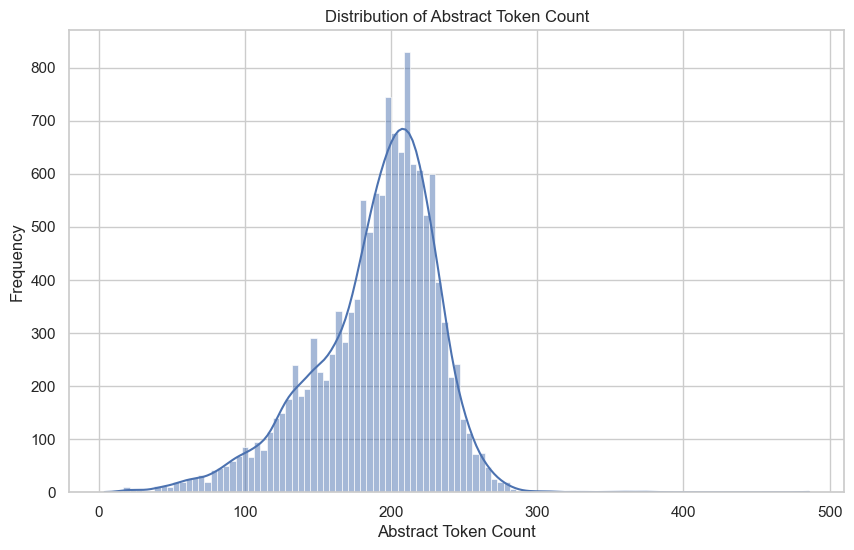

In [56]:
# Histogram for abstract token count
plt.figure(figsize=(10, 6))
sns.histplot(google_patent_en['abstract_token_count'], kde=True)
plt.title('Distribution of Abstract Token Count')
plt.xlabel('Abstract Token Count')
plt.ylabel('Frequency')
plt.show();

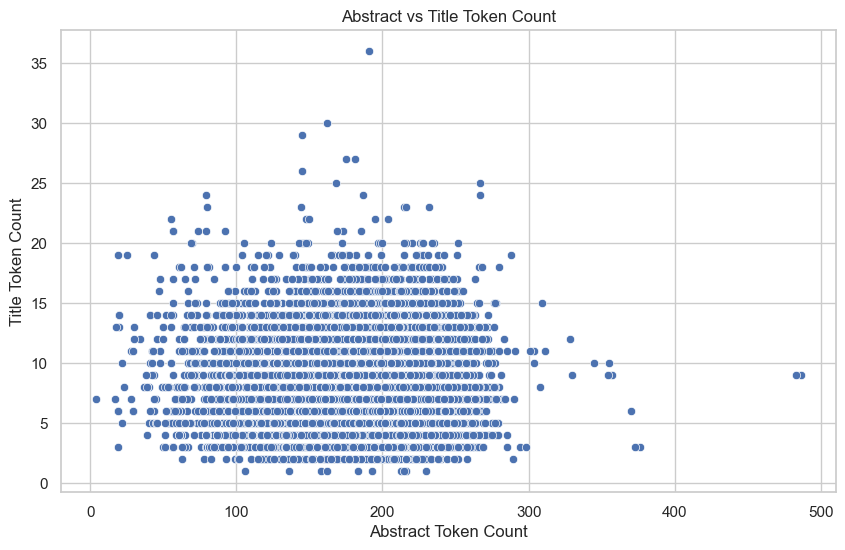

In [57]:
# Scatter plot for abstract vs title token count
plt.figure(figsize=(10, 6))
sns.scatterplot(data=google_patent_en, x='abstract_token_count', y='title_token_count')
plt.title('Abstract vs Title Token Count')
plt.xlabel('Abstract Token Count')
plt.ylabel('Title Token Count')
plt.show();

##### Cleantech Media

In [58]:
# Tokenizing text
ct_media['title_tokens'] = ct_media['title'].apply(word_tokenize)
ct_media['content_tokens'] = ct_media['content'].apply(word_tokenize)

# Counting tokens
ct_media['title_token_count'] = ct_media['title_tokens'].apply(len)
ct_media['content_token_count'] = ct_media['content_tokens'].apply(len)

# Print to verify
print("Token counts in titles amd content:")
ct_media[['title', 'title_token_count', 'content', 'content_token_count']].head()

Token counts in titles amd content:


,title,title_token_count,content,content_token_count
0,qatar to slash emissions as lng expansion adva...,8,qatar petroleum qp is targeting aggressive cut...,442
1,india launches its first 700 mw phwr,7,nuclear power corp of india ltd npcil synchro...,538
2,new chapter for uschina energy trade,6,new us president joe biden took office this we...,706
3,japan slow restarts cast doubt on 2030 energy ...,9,the slow pace of japanese reactor restarts con...,687
4,nyc pension funds to divest fossil fuel shares,8,two of new york citys largest pension funds sa...,394


In [59]:
# Determine minimum and maximum token counts across the dataset
min_title_tokens = ct_media['title_token_count'].min()
max_title_tokens = ct_media['title_token_count'].max()
min_content_tokens = ct_media['content_token_count'].min()
max_content_tokens = ct_media['content_token_count'].max()

print("\nMinimum and maximum token counts:")
print(f"Titles - Min: {min_title_tokens}, Max: {max_title_tokens}")
print(f"Contents - Min: {min_content_tokens}, Max: {max_content_tokens}")


Minimum and maximum token counts:
Titles - Min: 3, Max: 33
Contents - Min: 32, Max: 2932


###### Co-occurances analysation

In [60]:
# Calculate co-occurrences for the 'title_text' column
cooccurs_title = calculate_cooccurrences(ct_media, 'title')
print("\nCo-occurrences in titles:")
cooccurs_title.head()

# Calculate co-occurrences for the 'abstract_text' column
cooccurs_content = calculate_cooccurrences(ct_media, 'content')
print("Co-occurrences in contents:")
cooccurs_content.head()


Co-occurrences in titles:


,2021,2022,2023,address,archives,batteries,battery,california,carbon,charging,...,supply,systems,tech,technology,tesla,transition,uk,wind,world,zero
2021,0,2,0,0,0,1,0,1,1,0,...,1,1,0,2,3,2,2,3,3,0
2022,2,0,3,0,4,0,1,0,0,0,...,3,1,0,3,7,4,0,7,7,0
2023,0,3,0,0,0,0,2,0,0,1,...,4,3,0,0,1,3,5,5,6,0
address,0,0,0,0,0,0,0,1,4,0,...,0,15,1,6,1,1,6,2,1,0
archives,0,4,0,0,0,1,0,0,4,0,...,0,0,4,0,5,0,0,16,0,0


Co-occurrences in contents:


,04,05,10,100,1000,10000,100000,11,110,12,...,youtube,yoy,zach,zealand,zero,zerocarbon,zeroemission,zeroemissions,zone,zones
04,0,28,122,102,31,10,8,45,6,68,...,2,3,2,6,101,17,28,8,10,12
05,28,0,40,31,8,1,3,22,6,29,...,0,1,3,0,14,3,1,0,6,4
10,122,40,0,601,133,79,65,235,31,372,...,24,58,89,18,354,43,54,26,55,28
100,102,31,601,0,145,82,64,206,37,312,...,31,70,99,18,392,48,90,38,50,38
1000,31,8,133,145,0,19,13,40,3,69,...,8,12,15,5,72,9,21,7,9,8


###### Visualization

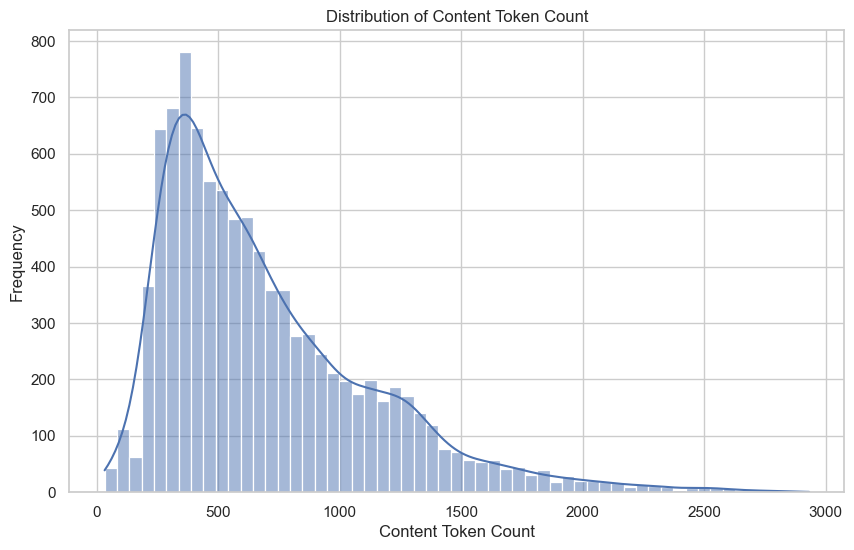

In [61]:
# Histogram for abstract token count
plt.figure(figsize=(10, 6))
sns.histplot(ct_media['content_token_count'], kde=True)
plt.title('Distribution of Content Token Count')
plt.xlabel('Content Token Count')
plt.ylabel('Frequency')
plt.show();

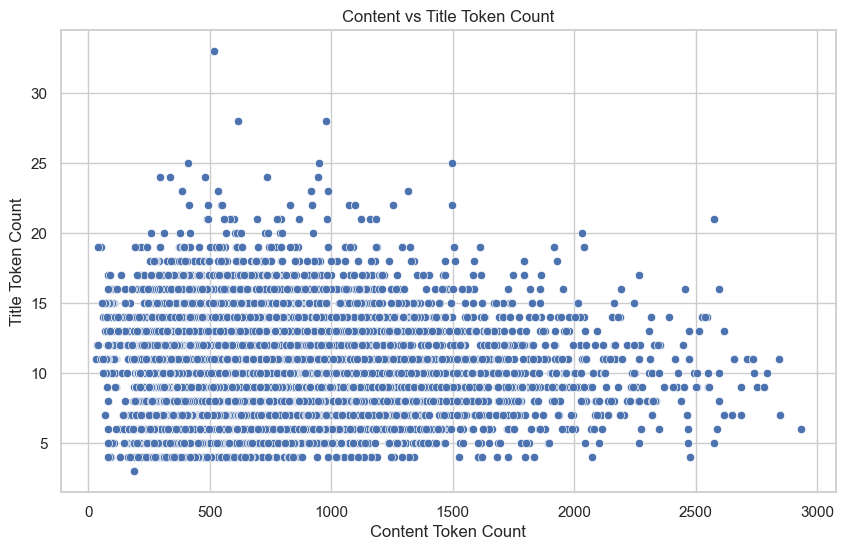

In [62]:
# Scatter plot for Content vs title token count
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ct_media, x='content_token_count', y='title_token_count')
plt.title('Content vs Title Token Count')
plt.xlabel('Content Token Count')
plt.ylabel('Title Token Count')
plt.show();

##### Cleantech Media Evalution

In [63]:
# Tokenizing text
ct_evaluation['question_tokens'] = ct_evaluation['question'].apply(word_tokenize)
ct_evaluation['relevant_chunk_tokens'] = ct_evaluation['relevant_chunk'].apply(word_tokenize)

# Counting tokens
ct_evaluation['question_token_count'] = ct_evaluation['question_tokens'].apply(len)
ct_evaluation['relevant_chunk_token_count'] = ct_evaluation['relevant_chunk_tokens'].apply(len)

# Print to verify
print("Token counts in question amd relevant_chunk:")
ct_evaluation[['question', 'question_token_count', 'relevant_chunk', 'relevant_chunk_token_count']].head()

Token counts in question amd relevant_chunk:


,question,question_token_count,relevant_chunk,relevant_chunk_token_count
0,what is the innovation behind leclanches new m...,12,leclanche said it has developed an environment...,36
1,what is the eus green deal industrial plan,8,the green deal industrial plan is a bid by the...,47
2,what is the eus green deal industrial plan,8,the european counterpart to the us inflation r...,35
3,what are the four focus areas of the eus green...,13,the new plan is fundamentally focused on four ...,42
4,when did the cooperation between gm and honda ...,13,what caught our eye was a new hookup between g...,60


In [64]:
# Determine minimum and maximum token counts across the dataset
min_question_tokens = ct_evaluation['question_token_count'].min()
max_question_tokens = ct_evaluation['question_token_count'].max()
min_relevant_chunk_tokens = ct_evaluation['relevant_chunk_token_count'].min()
max_relevant_chunk_tokens = ct_evaluation['relevant_chunk_token_count'].max()

print("\nMinimum and maximum token counts:")
print(f"Titles - Min: {min_question_tokens}, Max: {max_question_tokens}")
print(f"Relevant chunks - Min: {min_relevant_chunk_tokens}, Max: {max_relevant_chunk_tokens}")


Minimum and maximum token counts:
Titles - Min: 3, Max: 19
Relevant chunks - Min: 16, Max: 94


###### Co-occurances analysation

In [65]:
# Calculate co-occurrences for the 'title_text' column
cooccurs_question = calculate_cooccurrences(ct_evaluation, 'question')
print("\nCo-occurrences in questions:")
cooccurs_question.head()

# Calculate co-occurrences for the 'abstract_text' column
cooccurs_relevant_chunk = calculate_cooccurrences(ct_evaluation, 'relevant_chunk')
print("Co-occurrences in relevant chunks:")
cooccurs_relevant_chunk.head()


Co-occurrences in questions:


,2021,500m,absorption,agreements,agrivoltaics,aircraft,amorphous,antiesg,apples,areas,...,total,turbines,used,user,using,vehicles,warming,wavelengths,winters,zeroavias
2021,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
500m,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
absorption,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
agreements,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
agrivoltaics,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Co-occurrences in relevant chunks:


,1200,14,19seat,2012,2013,2021,2030,209,228,500,...,wildfires,winter,winters,wintertime,worked,year,yearround,years,zero,zeroavia
1200,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19seat,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2012,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2013,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


###### Visualization

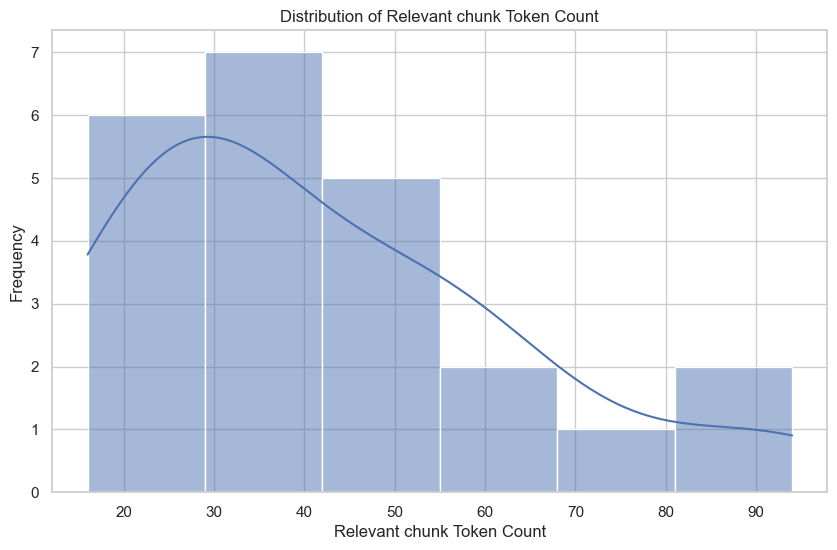

In [66]:
# Histogram for relevant chunk token count
plt.figure(figsize=(10, 6))
sns.histplot(ct_evaluation['relevant_chunk_token_count'], kde=True)
plt.title('Distribution of Relevant chunk Token Count')
plt.xlabel('Relevant chunk Token Count')
plt.ylabel('Frequency')
plt.show();

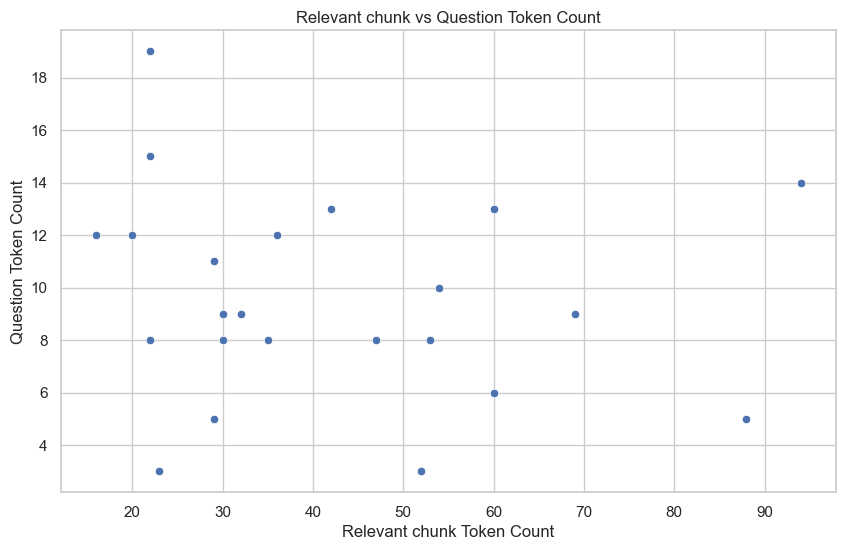

In [67]:
# Scatter plot for abstract vs title token count
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ct_evaluation, x='relevant_chunk_token_count', y='question_token_count')
plt.title('Relevant chunk vs Question Token Count')
plt.xlabel('Relevant chunk Token Count')
plt.ylabel('Question Token Count')
plt.show();

#### Stopwords

In [68]:
# Function to get top n unigrams
def get_top_n_words(corpus, n=None, stopwords=None):
    vec = CountVectorizer(stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Function to remove stopwords
def remove_stopwords(df, column1, column2):
    stop_words = set(stopwords.words('english'))

    # Define a function to remove stopwords from a list of tokens
    def filter_stopwords(tokens):
        return [word for word in tokens if word not in stop_words]

    # Apply the function to the specified column
    df[column2] = df[column2].apply(filter_stopwords)
    
    # Join the tokens back into a string for the specified column
    df[column1] = df[column2].apply(' '.join)

    return df


##### Google patent


<Axes: xlabel='count', ylabel='word'>

Text(0.5, 1.0, 'Top 20 Unigrams in Abstracts Without Stopwords')

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Word')

<Axes: xlabel='count', ylabel='word'>

Text(0.5, 1.0, 'Top 20 Unigrams in Abstracts With Stopwords Removed')

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Word')

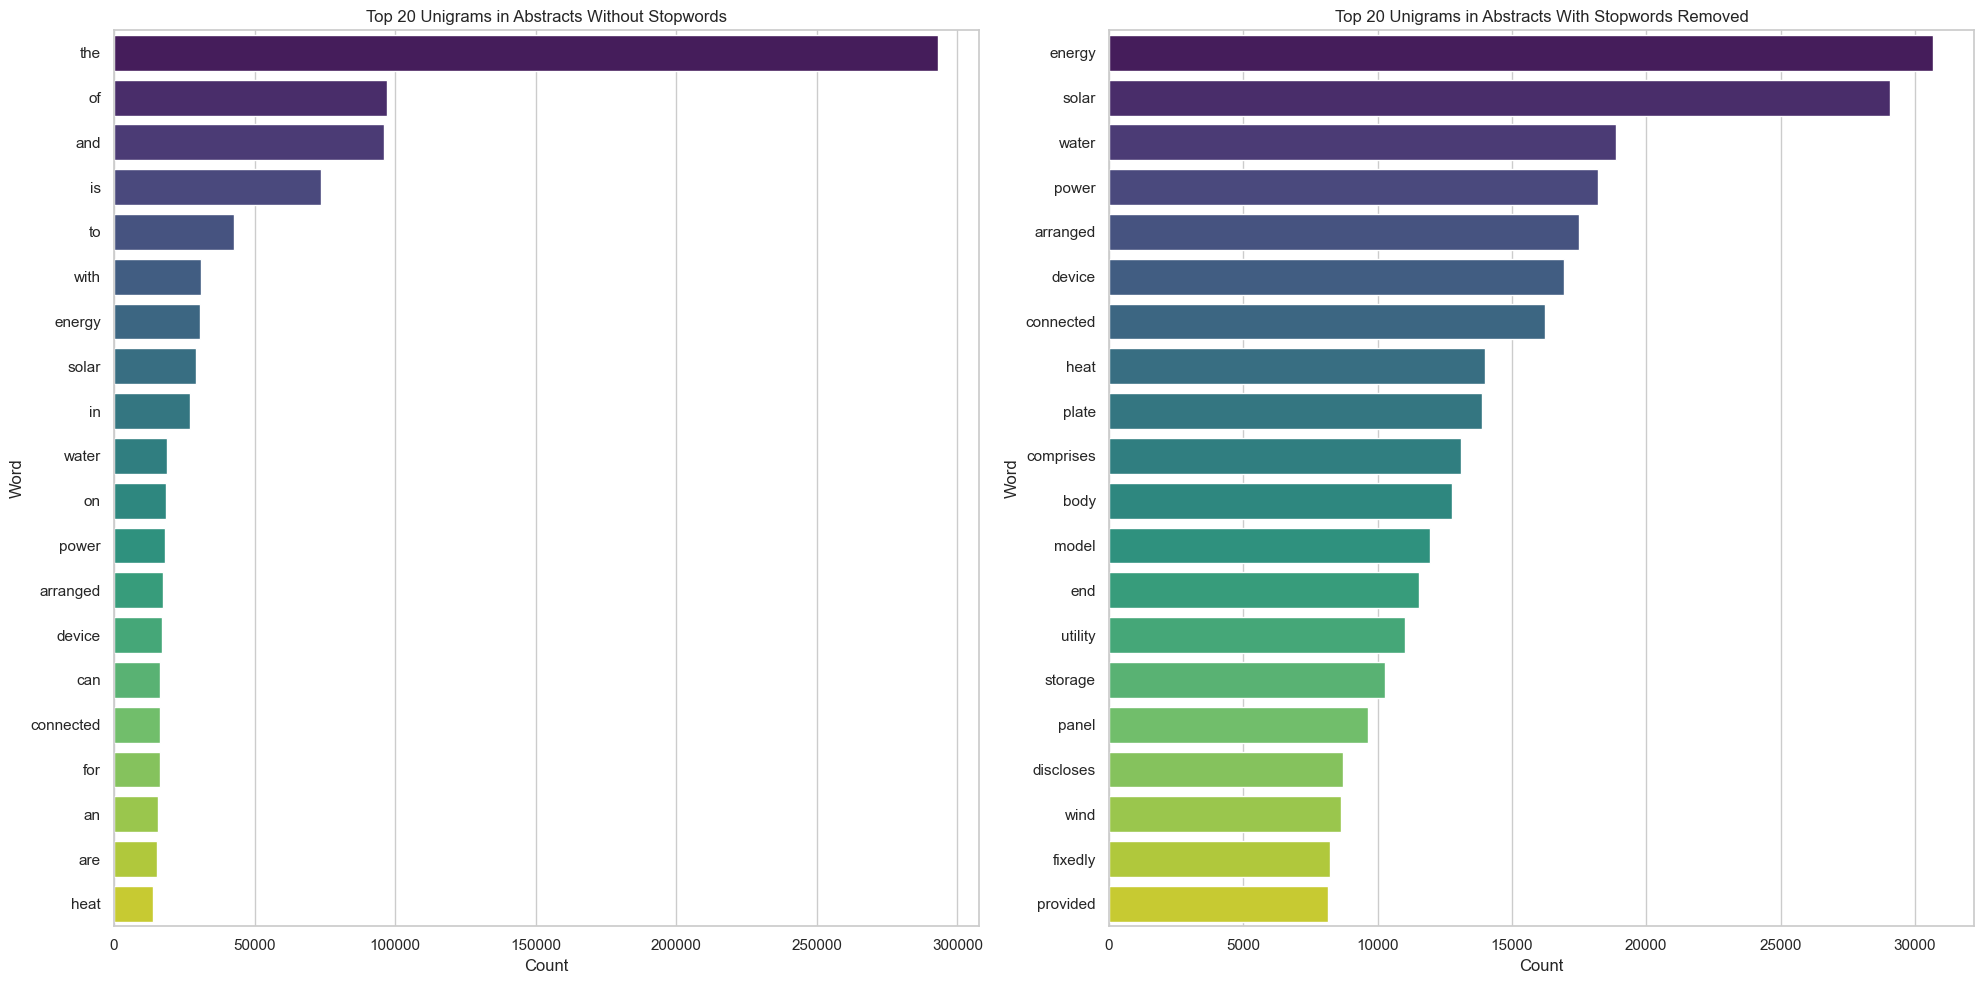

In [69]:
# Create Dataframe
top_n_unigrams = get_top_n_words(google_patent_en['abstract_localized_text'], n=20)
df_unigrams = pd.DataFrame(top_n_unigrams, columns=['word', 'count'])

top_n_unigrams_stop = get_top_n_words(google_patent_en['abstract_localized_text'], n=20, stopwords='english')
df_unigrams_stop = pd.DataFrame(top_n_unigrams_stop, columns=['word', 'count'])

# Setup matplotlib figures
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Display the unigram without stopwords
sns.barplot(ax=axes[0], x='count', y='word', hue='word', data=df_unigrams, palette='viridis')
axes[0].set_title('Top 20 Unigrams in Abstracts Without Stopwords')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')

# Display the unigram with stopwords removed
sns.barplot(ax=axes[1], x='count', y='word', hue='word', data=df_unigrams_stop, palette='viridis')
axes[1].set_title('Top 20 Unigrams in Abstracts With Stopwords Removed')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

plt.tight_layout()
plt.show()

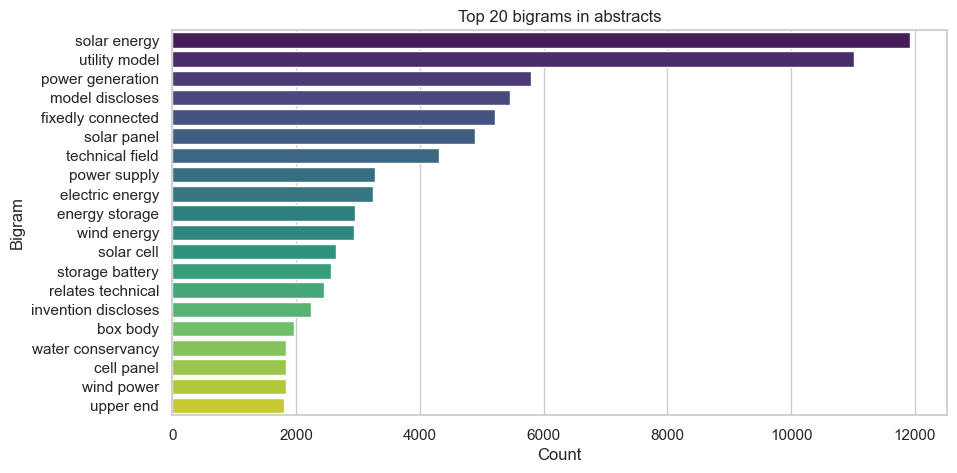

In [70]:
# Get the top n bigrams from the abstracts
top_n_bigrams = get_top_n_bigrams(google_patent_en['abstract_localized_text'], n=20)
df_bigrams = pd.DataFrame(top_n_bigrams, columns=['bigram', 'count'])

# Plot the top n bigrams
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='bigram', data=df_bigrams, palette='viridis', hue='bigram')
plt.title('Top 20 bigrams in abstracts')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show();

In [71]:
google_patent_en = remove_stopwords(google_patent_en, 'title_localized_text', 'title_tokens')
google_patent_en = remove_stopwords(google_patent_en, 'abstract_localized_text', 'abstract_tokens')
google_patent_en

,publication_number,country_code,publication_date,title_localized_text,abstract_localized_text,title_tokens,abstract_tokens,title_token_count,abstract_token_count
0,US-2022239235-A1,US,2022-07-28,adaptable dcac inverter drive system operation,disclosed adaptable dcac inverter system opera...,"[adaptable, dcac, inverter, drive, system, ope...","[disclosed, adaptable, dcac, inverter, system,...",7,64
8,US-2022239251-A1,US,2022-07-28,system providing energy single contiguous sola...,accordance example embodiment solar energy sys...,"[system, providing, energy, single, contiguous...","[accordance, example, embodiment, solar, energ...",18,92
12,US-11396827-B2,US,2022-07-26,control method optimizing solartopower efficie...,control method optimizing solartopower efficie...,"[control, method, optimizing, solartopower, ef...","[control, method, optimizing, solartopower, ef...",15,149
16,CN-114772674-A,CN,2022-07-22,lowcarbon running saline wastewater treatment ...,invention discloses system method treating low...,"[lowcarbon, running, saline, wastewater, treat...","[invention, discloses, system, method, treatin...",15,226
17,CN-217026795-U,CN,2022-07-22,water ecological remediation device convenient...,utility model discloses water ecological resto...,"[water, ecological, remediation, device, conve...","[utility, model, discloses, water, ecological,...",7,252
...,...,...,...,...,...,...,...,...,...
117999,CN-214850044-U,CN,2021-11-23,box transformer substation capable adjusting o...,utility model relates case becomes technical f...,"[box, transformer, substation, capable, adjust...","[utility, model, relates, case, becomes, techn...",10,179
118001,CN-214840532-U,CN,2021-11-23,garden waste anaerobic fermentation coupling m...,utility model discloses gardens discarded obje...,"[garden, waste, anaerobic, fermentation, coupl...","[utility, model, discloses, gardens, discarded...",12,202
118007,CN-214835218-U,CN,2021-11-23,unmanned aerial vehicle hangar function charging,utility model relates unmanned air vehicle tec...,"[unmanned, aerial, vehicle, hangar, function, ...","[utility, model, relates, unmanned, air, vehic...",8,214
118011,CN-113690940-A,CN,2021-11-23,wind power supply control method,invention provides wind power supply control m...,"[wind, power, supply, control, method]","[invention, provides, wind, power, supply, con...",5,184


##### Cleantech Media

<Axes: xlabel='count', ylabel='word'>

Text(0.5, 1.0, 'Top 20 Unigrams in Contents Without Stopwords')

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Word')

<Axes: xlabel='count', ylabel='word'>

Text(0.5, 1.0, 'Top 20 Unigrams in Contents With Stopwords Removed')

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Word')

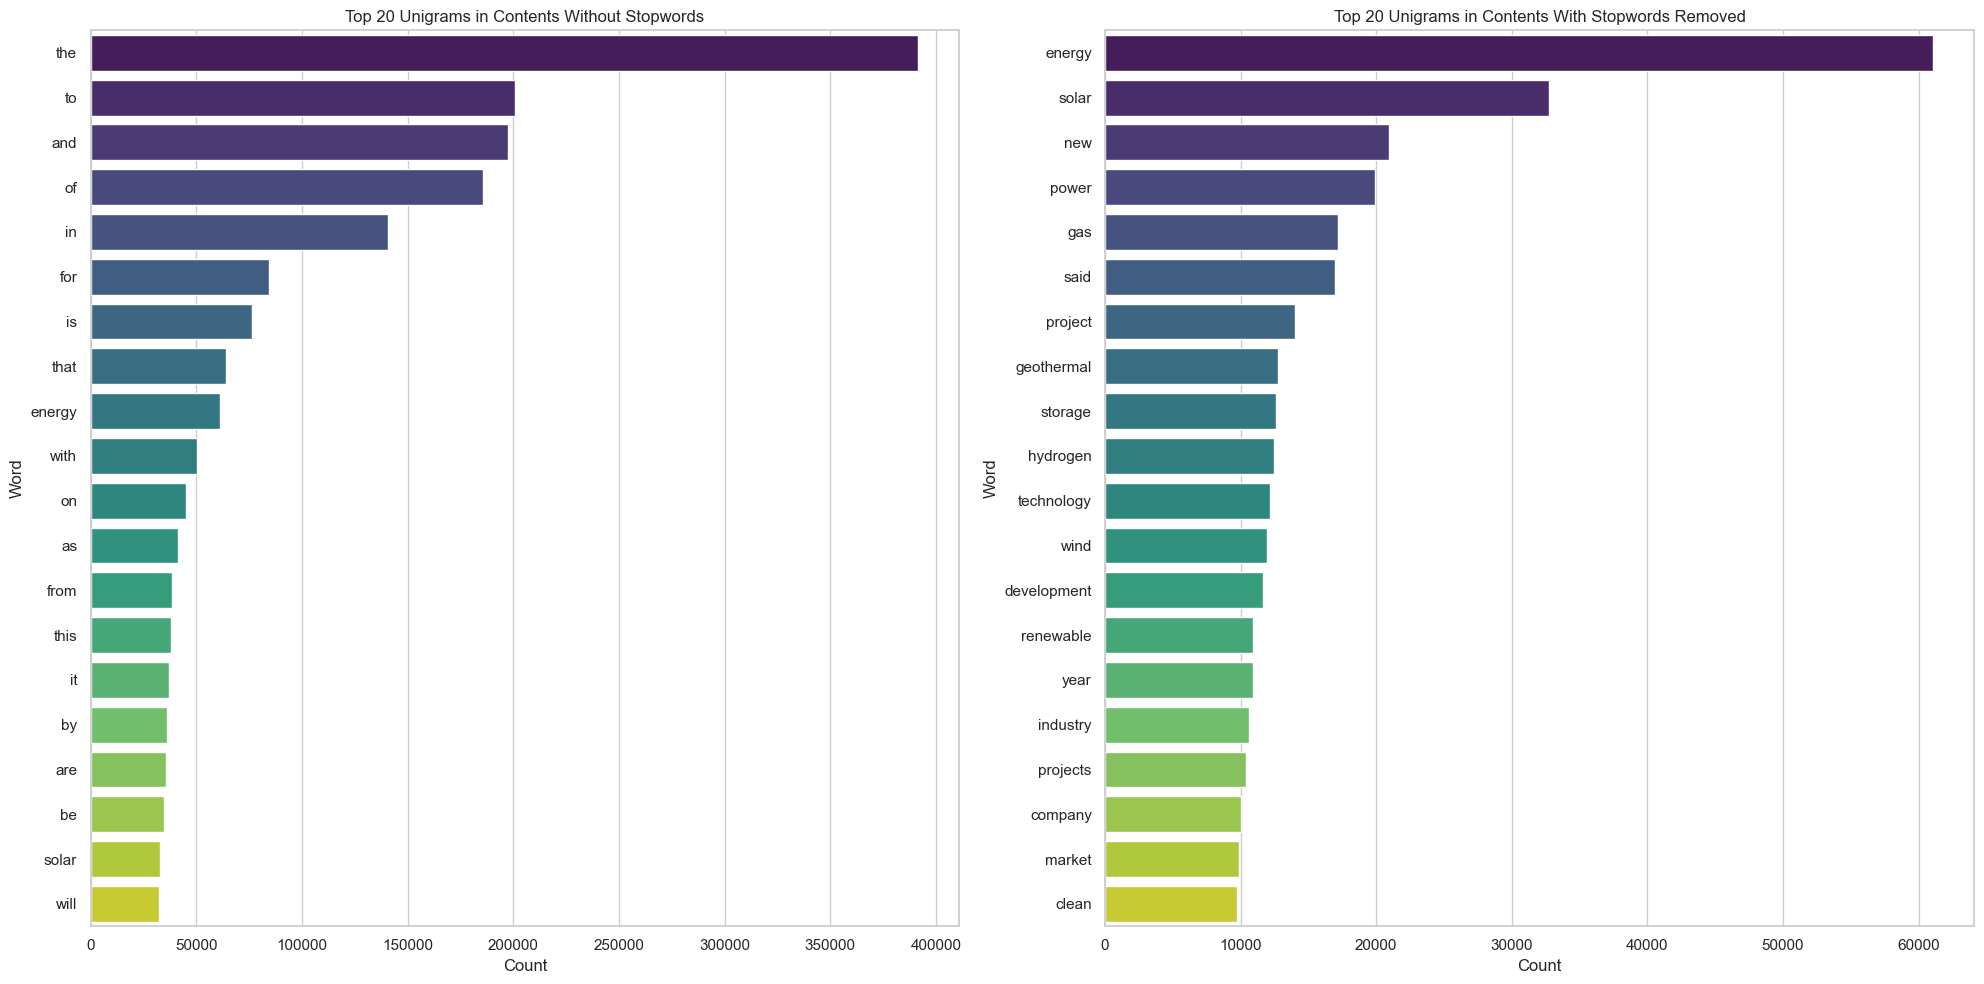

In [72]:
# Create Dataframe
top_n_unigrams = get_top_n_words(ct_media['content'], n=20)
df_unigrams = pd.DataFrame(top_n_unigrams, columns=['word', 'count'])

top_n_unigrams_stop = get_top_n_words(ct_media['content'], n=20, stopwords='english')
df_unigrams_stop = pd.DataFrame(top_n_unigrams_stop, columns=['word', 'count'])

# Setup matplotlib figures
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Display the unigram without stopwords
sns.barplot(ax=axes[0], x='count', y='word', hue='word', data=df_unigrams, palette='viridis')
axes[0].set_title('Top 20 Unigrams in Contents Without Stopwords')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')

# Display the unigram with stopwords removed
sns.barplot(ax=axes[1], x='count', y='word', hue='word', data=df_unigrams_stop, palette='viridis')
axes[1].set_title('Top 20 Unigrams in Contents With Stopwords Removed')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

plt.tight_layout()
plt.show()

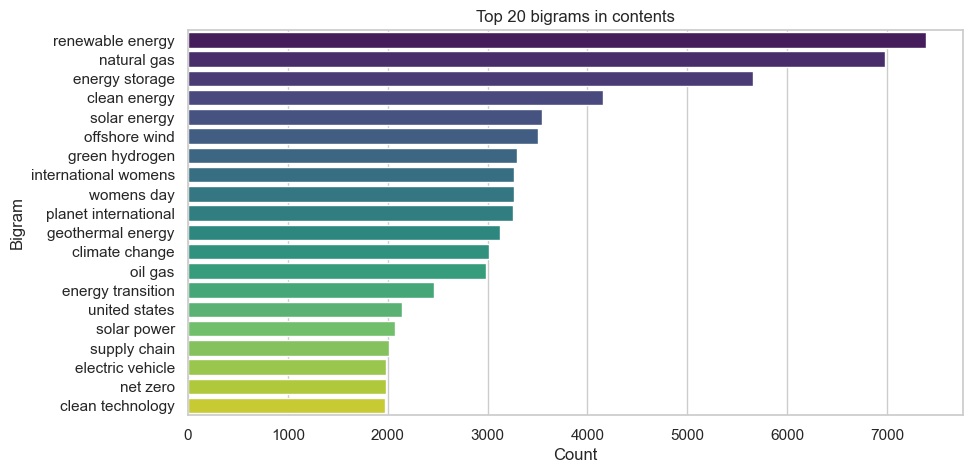

In [73]:
# Get the top n bigrams from the abstracts
top_n_bigrams = get_top_n_bigrams(ct_media['content'], n=20)
df_bigrams = pd.DataFrame(top_n_bigrams, columns=['bigram', 'count'])

# Plot the top n bigrams
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='bigram', data=df_bigrams, palette='viridis', hue='bigram')
plt.title('Top 20 bigrams in contents')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show();

In [74]:
ct_media = remove_stopwords(ct_media, 'title', 'title_tokens')
ct_media = remove_stopwords(ct_media, 'content', 'content_tokens')
ct_media

,title,date,content,domain,title_tokens,content_tokens,title_token_count,content_token_count
0,qatar slash emissions lng expansion advances,2021-01-13,qatar petroleum qp targeting aggressive cuts g...,energyintel,"[qatar, slash, emissions, lng, expansion, adva...","[qatar, petroleum, qp, targeting, aggressive, ...",8,442
1,india launches first 700 mw phwr,2021-01-15,nuclear power corp india ltd npcil synchronize...,energyintel,"[india, launches, first, 700, mw, phwr]","[nuclear, power, corp, india, ltd, npcil, sync...",7,538
2,new chapter uschina energy trade,2021-01-20,new us president joe biden took office week us...,energyintel,"[new, chapter, uschina, energy, trade]","[new, us, president, joe, biden, took, office,...",6,706
3,japan slow restarts cast doubt 2030 energy plan,2021-01-22,slow pace japanese reactor restarts continues ...,energyintel,"[japan, slow, restarts, cast, doubt, 2030, ene...","[slow, pace, japanese, reactor, restarts, cont...",9,687
4,nyc pension funds divest fossil fuel shares,2021-01-25,two new york citys largest pension funds say d...,energyintel,"[nyc, pension, funds, divest, fossil, fuel, sh...","[two, new, york, citys, largest, pension, fund...",8,394
...,...,...,...,...,...,...,...,...
9588,strata clean energy nets 300 million funding s...,2023-11-06,strata clean energy closed 300 million revolvi...,solarindustrymag,"[strata, clean, energy, nets, 300, million, fu...","[strata, clean, energy, closed, 300, million, ...",11,290
9589,orsted deploying sparkcognition renewable suit...,2023-11-07,global renewable energy developer orsted deplo...,solarindustrymag,"[orsted, deploying, sparkcognition, renewable,...","[global, renewable, energy, developer, orsted,...",9,313
9590,veolia plans 5 mw solar arkansas,2023-11-07,veolia north america provider environmental so...,solarindustrymag,"[veolia, plans, 5, mw, solar, arkansas]","[veolia, north, america, provider, environment...",10,338
9591,sunedison big fast,2023-11-08,selfproclaimed leading renewable power plant d...,solarindustrymag,"[sunedison, big, fast]","[selfproclaimed, leading, renewable, power, pl...",5,1695


##### Cleantech Media Evalution

<Axes: xlabel='count', ylabel='word'>

Text(0.5, 1.0, 'Top 20 Unigrams in Relevant chunks Without Stopwords')

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Word')

<Axes: xlabel='count', ylabel='word'>

Text(0.5, 1.0, 'Top 20 Unigrams in Relevant chunks With Stopwords Removed')

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Word')

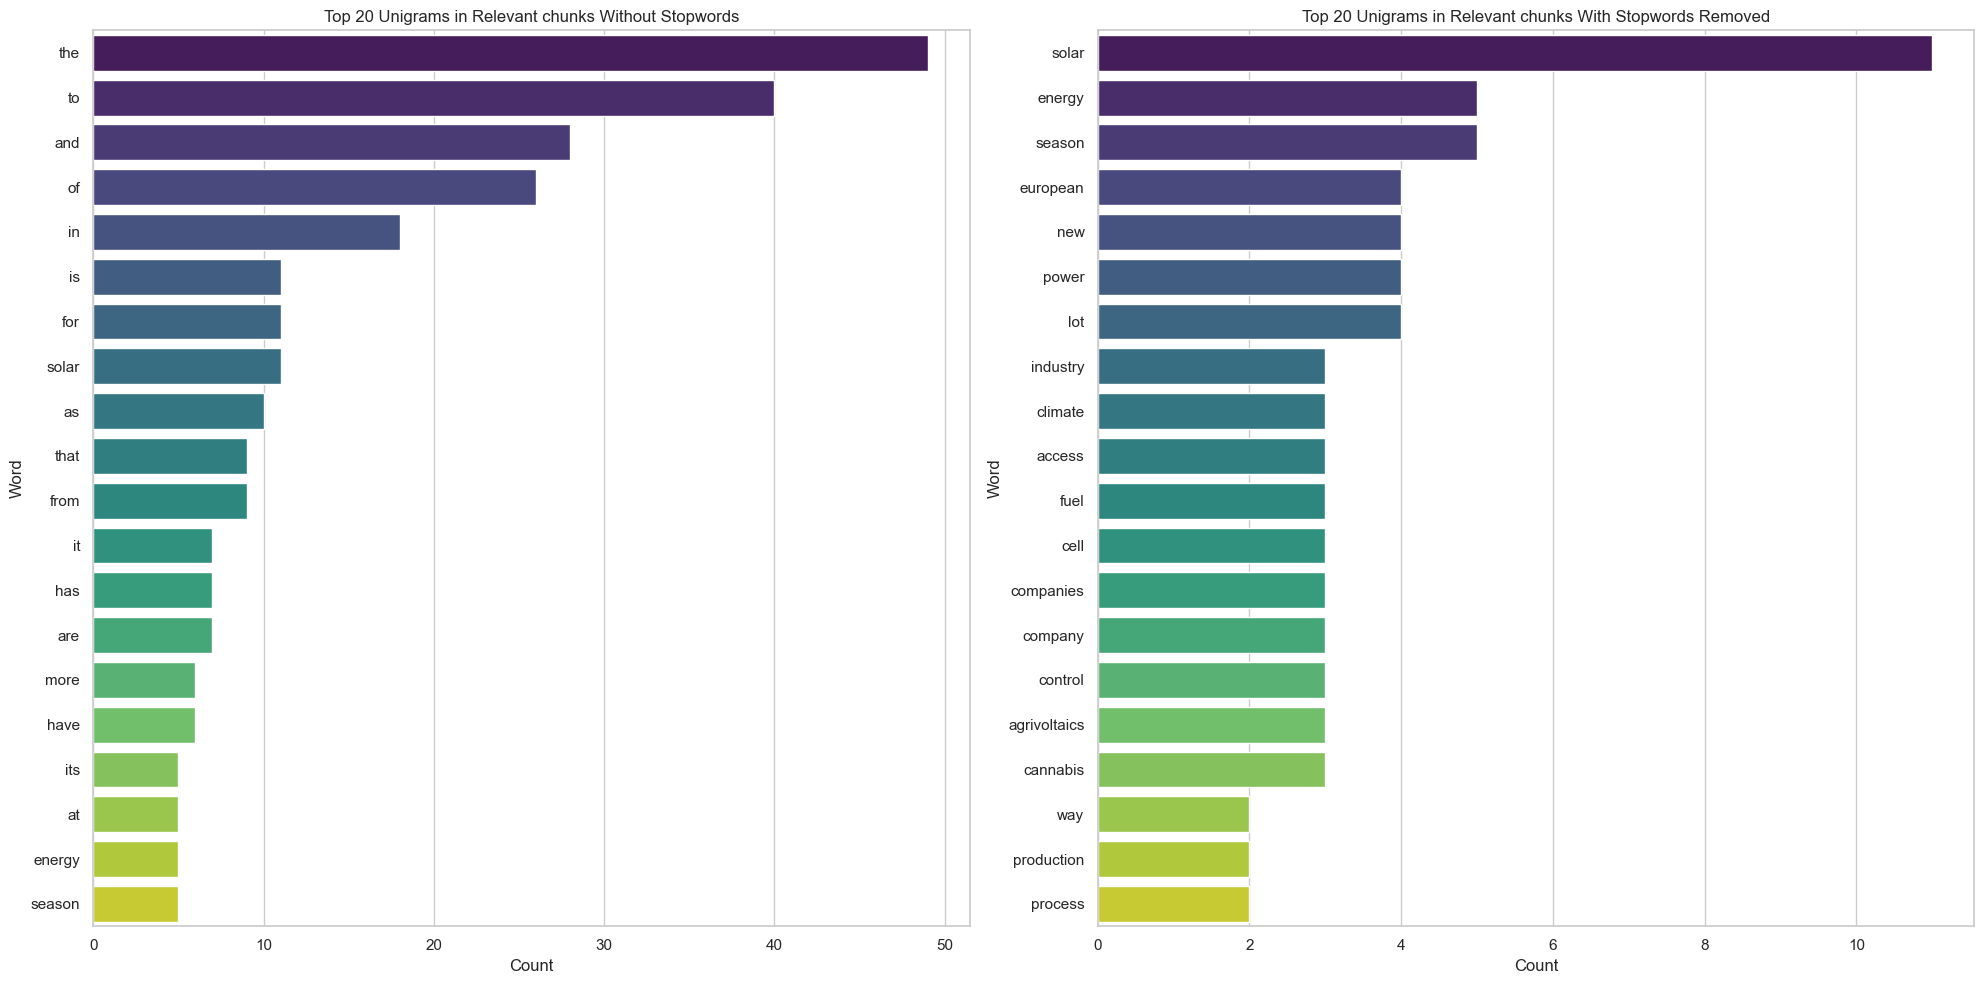

In [75]:
# Create Dataframe
top_n_unigrams = get_top_n_words(ct_evaluation['relevant_chunk'], n=20)
df_unigrams = pd.DataFrame(top_n_unigrams, columns=['word', 'count'])

top_n_unigrams_stop = get_top_n_words(ct_evaluation['relevant_chunk'], n=20, stopwords='english')
df_unigrams_stop = pd.DataFrame(top_n_unigrams_stop, columns=['word', 'count'])

# Setup matplotlib figures
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Display the unigram without stopwords
sns.barplot(ax=axes[0], x='count', y='word', hue='word', data=df_unigrams, palette='viridis')
axes[0].set_title('Top 20 Unigrams in Relevant chunks Without Stopwords')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')

# Display the unigram with stopwords removed
sns.barplot(ax=axes[1], x='count', y='word', hue='word', data=df_unigrams_stop, palette='viridis')
axes[1].set_title('Top 20 Unigrams in Relevant chunks With Stopwords Removed')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

plt.tight_layout()
plt.show()

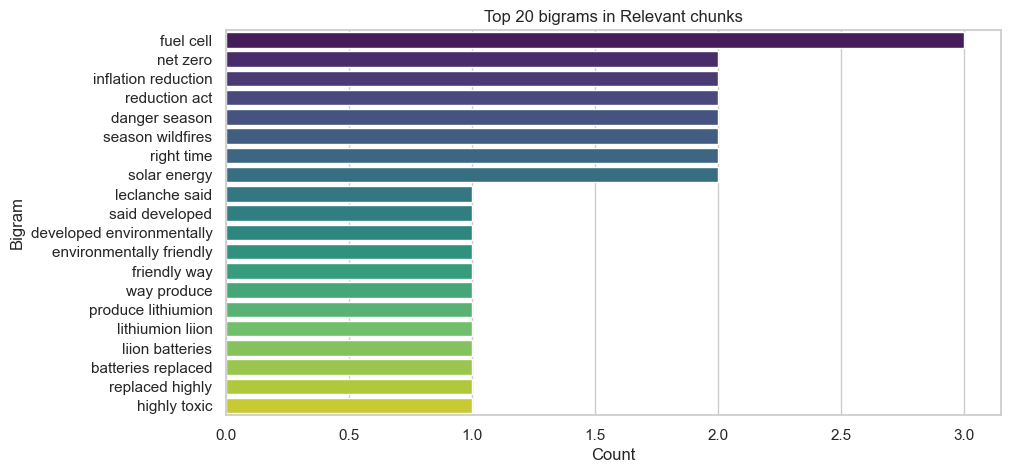

In [76]:
# Get the top n bigrams from the abstracts
top_n_bigrams = get_top_n_bigrams(ct_evaluation['relevant_chunk'], n=20)
df_bigrams = pd.DataFrame(top_n_bigrams, columns=['bigram', 'count'])

# Plot the top n bigrams
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='bigram', data=df_bigrams, palette='viridis', hue='bigram')
plt.title('Top 20 bigrams in Relevant chunks')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show();

In [77]:
ct_evaluation = remove_stopwords(ct_evaluation, 'question', 'question_tokens')
ct_evaluation = remove_stopwords(ct_evaluation, 'relevant_chunk', 'relevant_chunk_tokens')
ct_evaluation

,example_id,question_id,question,relevant_chunk,domain,question_tokens,relevant_chunk_tokens,question_token_count,relevant_chunk_token_count
0,1,1,innovation behind leclanches new method produc...,leclanche said developed environmentally frien...,sgvoice.net,"[innovation, behind, leclanches, new, method, ...","[leclanche, said, developed, environmentally, ...",12,36
1,2,2,eus green deal industrial plan,green deal industrial plan bid eu make net zer...,sgvoice.net,"[eus, green, deal, industrial, plan]","[green, deal, industrial, plan, bid, eu, make,...",8,47
2,3,2,eus green deal industrial plan,european counterpart us inflation reduction ac...,pv-magazine.com,"[eus, green, deal, industrial, plan]","[european, counterpart, us, inflation, reducti...",8,35
3,4,3,four focus areas eus green deal industrial plan,new plan fundamentally focused four areas pill...,sgvoice.net,"[four, focus, areas, eus, green, deal, industr...","[new, plan, fundamentally, focused, four, area...",13,42
4,5,4,cooperation gm honda fuel cell vehicles start,caught eye new hookup gm honda honda also hamm...,cleantechnica.com,"[cooperation, gm, honda, fuel, cell, vehicles,...","[caught, eye, new, hookup, gm, honda, honda, a...",13,60
5,6,5,colgatepalmolive enter ppa agreements solar de...,scout clean energy coloradobased renewable ene...,solarindustrymag.com,"[colgatepalmolive, enter, ppa, agreements, sol...","[scout, clean, energy, coloradobased, renewabl...",9,32
6,7,6,status zeroavias hydrogen fuel cell electric a...,december us startup zeroavia announced retrofi...,cleantechnica.com,"[status, zeroavias, hydrogen, fuel, cell, elec...","[december, us, startup, zeroavia, announced, r...",11,29
7,8,7,danger season,spring turns summer days warm northern hemisph...,cleantechnica.com,"[danger, season]","[spring, turns, summer, days, warm, northern, ...",5,88
8,9,8,mississipi antiesg state,mississippi among two dozen states republican ...,cleantechnica.com,"[mississipi, antiesg, state]","[mississippi, among, two, dozen, states, repub...",5,29
9,10,9,hang solar panels garden fences,scaling farm garden level another company offe...,cleantechnica.com,"[hang, solar, panels, garden, fences]","[scaling, farm, garden, level, another, compan...",8,53


#### Lemmatization (or Stemming)

##### Google patent

##### Cleantech Media

##### Cleantech Media Evalution

#### Export

In [78]:
#google_patent_en.to_csv(f"Data/google_patent_en_preprocessed.csv", index=False)
#ct_media.to_csv(f"Data/ct_media_preprocessed.csv", index=False)
#ct_evaluation.to_csv(f"Data/ct_evaluation_preprocessed.csv", index=False)